### **Abstract**

This report presents a focused study on response times in tokenization and detokenization techniques across language models. Our project begins with research into tokenization methods, including Byte-Pair Encoding (BPE), WordPiece, and SentencePiece, emphasizing their significance in natural language processing. We select language models from the Hugging Face libraries that employ these techniques and measure response times using Python.

We analysed batched and unbatched data processing and evaluated the nuances between them. We carefully choosed the corpora, considering size and efficiency, from Hugging Face's dataset repository. A flexible framework is established to assess timing disparities among various language models.

To enhance the comparison, we introduce the Spacy library as an external model. Language models for English, Chinese, and Spanish are chosen, and their run times are analyzed through associated language models. The analysis phase focuses on discerning efficiency, considering factors like tokenization, detokenization, and data batching.

Our findings are presented visually, offering insights into response time disparities among different model tokenization methods and data processing approaches. This project aims to provide practical insights into language processing efficiency and inform model selection for different languages.

### **Project Methodology**

For the purpose of this assignment, our central objective is to conduct a thorough examination of response time variations associated with diverse tokenization and detokenization techniques implemented across various language models. Our approach is multifaceted, encompassing comparisons of tokenization techniques, the utilization of both batched and unbatched data, and evaluations across distinct corpora. Additionally, we broaden our scope beyond the Hugging Face libraries by incorporating an external library called Spacy into our research. It is important to recognize that tokenization holds an important part in natural language processing, enabling the efficient manipulation of textual data.

The initial phase of our project involves an extensive exploration of various tokenization types, such as Byte-Pair Encoding (BPE), WordPiece, and SentencePiece, coupled with a comprehensive understanding of the underlying necessity of tokenization. Subsequently, we narrow our focus to language models employing these distinct tokenization methods, all of which are readily accessible within the Hugging Face libraries. To ensure precision in recording response times, we utilized Python's time module to measure the execution durations of both tokenization and detokenization processes.

In addition, we introduced an external library, Spacy, into our research. This additional tool permits an exploration of alternative approaches to tokenization and detokenization, facilitating a side-by-side evaluation of Spacy's performance alongside the models we have chosen from the Hugging Face libraries.

Furthermore, we delve into the complexities of batched and unbatched data. Batched data refers to the grouping of text for simultaneous processing, while unbatched data is processed individually. We carefully explored the nuances between these two data types, analyzing the time differentials for the tokenization and detokenization of each token.

To ensure meaningful experimentation and to account for potential variability, we ran our code for each model and technique a total of 10 times. This iterative approach allowed us to obtain consistent measurements and ensure the reliability of our results.

To ensure fairness and accuracy in our testing, we adhered to strict guidelines to ensure consistency. Each language model underwent an identical process, encompassing both batched and unbatched data, for both tokenization and detokenization. This approach guaranteed a consistent and precise measurement of processes and timings across all models.

In the analysis phase, we meticulously studied the timing data collected throughout our research to achieve a comprehensive understanding of response times linked to various tokenization and detokenization techniques. Our objective is to identify factors influencing processing times, determine the most efficient tokenization method, and ascertain whether batched or unbatched data processing yields better outcomes.

Furthermore, we employed data visualization techniques to effectively present our findings. Through the creation of informative charts and graphs, we were able to study and analyze disparities in response times between different tokenization methods and data processing approaches. These visual aids helped us in our research and revealed key insights.

The analysis we conducted aims to shed light on the nuances of response times in tokenization and detokenization, providing valuable insights for the field of natural language processing.

# `Project Dependencies`

In [ ]:
!pip install -U pip setuptools wheel
!pip install -U spacy
!python -m spacy download en_core_web_sm
!python -m spacy download zh_core_web_sm
!python -m spacy download es_core_news_sm
!pip install transformers
!pip install sentencepiece
!pip install datasets
!pip install gdown

2023-10-05 18:53:09.868061: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 21.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
2023-10-05 18:53:36.923740: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.5/48.5 MB 10.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('zh_core_web_sm')
2023-10-05 18:54:01.123187: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 22.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')


In [ ]:
!git clone https://github.com/Yapping72/ICT3102-e-mc2-assignment-1.git

Cloning into 'ICT3102-e-mc2-assignment-1'...
remote: Enumerating objects: 73, done.
remote: Counting objects: 100% (73/73), done.
remote: Compressing objects: 100% (55/55), done.
remote: Total 73 (delta 34), reused 42 (delta 14), pack-reused 0
Receiving objects: 100% (73/73), 4.81 MiB | 12.66 MiB/s, done.
Resolving deltas: 100% (34/34), done.


# `Project Code`

Updated Project Code With detokenisation

In [ ]:
from transformers import AutoTokenizer
from datasets import load_dataset
import time
import os

# byte_pair_tokenization = ["openai-gpt", "gpt2", "NousResearch/Llama-2-13b-hf"]
# unigram_tokenization = ["google/bigbird-roberta-base", "facebook/mbart-large-50-many-to-many-mmt" , "albert-base-v2" , "xlnet-base-cased"]
# wordpiece_tokenization = ['distilbert-base-uncased','google/mobilebert-uncased','funnel-transformer/small-base','sentence-transformers/all-mpnet-base-v2']
# sentencepiece_tokenization = ["google/flan-t5-base"]

#corpus = ["I have a new GPU!", "I wonder how fast the model will train on this.","Hello there"]

dataset = load_dataset("HuggingFaceH4/self-instruct-seed")
corpus = dataset['train']['instruction']
dataset2 = load_dataset("fka/awesome-chatgpt-prompts")
corpus2 = dataset2['train']['prompt']


def save_corpus_as_text_file(corpus, output_path: str):
  with open(output_path, "w", encoding="utf-8") as file:
    for line in corpus:
      line = line.replace("\n", " ")
      file.write(line + "\n")


base_path = os.path.join("ICT3102-e-mc2-assignment-1", "Datasets") # Replace with where your translated corpora exists.
original_corpus_1 = os.path.join(base_path, "original_corpus_1.txt")
original_corpus_2 = os.path.join(base_path, "original_corpus_2.txt")

save_corpus_as_text_file(corpus, original_corpus_1)
save_corpus_as_text_file(corpus2, original_corpus_2)

def initialize_model(model_name: str):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    return tokenizer

#Unbatched data
def time_model(tokenizer_object, text, tokenize=True):
    if tokenize:
        # Capture the start time
        start_time = time.time()
        tokenizer_object.encode_plus(text)
    else:
        tokens = tokenizer_object.encode_plus(text)
        # Capture the start time
        start_time = time.time()
        tokenizer_object.decode(tokens['input_ids'], skip_special_tokens=True)

    # Capture the end time
    end_time = time.time()
    # Calculate the elapsed time in milliseconds
    elapsed_time = (end_time - start_time) * 1e3
    return elapsed_time

def analyse_encode_plus(tokenizers: list, corpus: list, num_runs: int) -> dict:
    results = {}
    results['method'] = "Unbatched"

    for hugging_face_tokenizer in tokenizers:
        try:
            tokenizer = initialize_model(hugging_face_tokenizer)
            total_time_tokenization = 0  # Total time for tokenization
            total_time_detokenization = 0  # Total time for detokenization

            for _ in range(num_runs):
                for text in corpus:
                    # Tokenize each line in the corpus individually
                    tokenization_time = time_model(tokenizer, text, tokenize=True)
                    total_time_tokenization += tokenization_time

                    # Detokenize the encoded text
                    detokenization_time = time_model(tokenizer, text, tokenize=False)
                    total_time_detokenization += detokenization_time

            # Calculate the average time for tokenization and detokenization
            avg_tokenization_time = total_time_tokenization / num_runs
            avg_detokenization_time = total_time_detokenization / num_runs

            # Extract tokenizer name or path for dictionary key
            tokenizer_name = tokenizer.name_or_path
            results[tokenizer_name] = {
                "Tokenization": avg_tokenization_time,
                "Detokenization": avg_detokenization_time
            }

            print(f"{tokenizer_name}:")
            print(f"Average Tokenization Time: {avg_tokenization_time} ms")
            print(f"Average Detokenization Time: {avg_detokenization_time} ms")
        except Exception as e:
            print(f"Error occurred for {hugging_face_tokenizer}: {e}")
            continue

    return results


def time_model_batch(tokenizer, corpus,tokenize=True):

    if tokenize:
        # Capture the start time
        start_time = time.time()
        tokenizer.batch_encode_plus(corpus)
    else:
        tokens = tokenizer.batch_encode_plus(corpus)
        # Capture the start time
        start_time = time.time()
        tokenizer.batch_decode(tokens['input_ids'], skip_special_tokens=True)

    # Capture the end time
    end_time = time.time()
    # Calculate the elapsed time in milliseconds
    elapsed_time = (end_time - start_time) * 1e3
    return elapsed_time

def analyse_batch(tokenizers: list, corpus: list, num_runs: int) -> dict:
    results = {}
    results['method'] = "Batched"

    for hugging_face_tokenizer in tokenizers:
        tokenizer = initialize_model(hugging_face_tokenizer)
        try:
            tokenization_times = []
            detokenization_times = []

            for _ in range(num_runs):
                # Get time for tokenization
                tokenization_time = time_model_batch(tokenizer, corpus, tokenize=True)
                tokenization_times.append(tokenization_time)

                # Get time for detokenization
                detokenization_time = time_model_batch(tokenizer, corpus, tokenize=False)
                detokenization_times.append(detokenization_time)

            # Extract tokenizer name or path for dictionary key
            tokenizer_name = tokenizer.name_or_path
            results[tokenizer_name] = {
                "Tokenization": sum(tokenization_times) / num_runs,
                "Detokenization": sum(detokenization_times) / num_runs
            }

            print(f"{tokenizer_name}:")
            print(f"Average Tokenization Time: {sum(tokenization_times) / num_runs} ms")
            print(f"Average Detokenization Time: {sum(detokenization_times) / num_runs} ms")
        except Exception as e:
            print(f"Error occurred for {hugging_face_tokenizer}: {e}")
            continue

    return results


## Openai , Gpt2 , Llama Analysis for Unbatched and Batched data

In [ ]:
byte_pair = ["openai-gpt", "gpt2", "NousResearch/Llama-2-13b-hf"]
print("--------------------------Unbatched Data-------------------------------")
byte_pair_timing_unbatched = analyse_encode_plus(byte_pair, corpus,10)
print("--------------------------Batched Data-------------------------------")
byte_pair_timing_batched = analyse_batch(byte_pair,corpus,10)

--------------------------Unbatched Data-------------------------------


openai-gpt:
Average Tokenization Time: 64.59822654724121 ms
Average Detokenization Time: 1306.7325830459595 ms


gpt2:
Average Tokenization Time: 43.50428581237793 ms
Average Detokenization Time: 61.037302017211914 ms


NousResearch/Llama-2-13b-hf:
Average Tokenization Time: 14.987850189208984 ms
Average Detokenization Time: 28.032946586608887 ms
--------------------------Batched Data-------------------------------
openai-gpt:
Average Tokenization Time: 11.788034439086914 ms
Average Detokenization Time: 26.524782180786133 ms
gpt2:
Average Tokenization Time: 18.2891845703125 ms
Average Detokenization Time: 43.33786964416504 ms
NousResearch/Llama-2-13b-hf:
Average Tokenization Time: 12.381339073181152 ms
Average Detokenization Time: 48.55194091796875 ms


## Distilbert-base-uncased , mobilebert-uncased , Funnel Transformers, Mpnet Analysis for Unbatched and Batched Data

In [ ]:
# Get response time for word_piece models
word_piece =['distilbert-base-uncased','google/mobilebert-uncased','funnel-transformer/small-base','sentence-transformers/all-mpnet-base-v2']
print("--------------------------Unbatched Data-------------------------------")
word_piece_timing_unbatched = analyse_encode_plus(word_piece, corpus,10)
print("--------------------------Batched Data-------------------------------")
word_piece_timing_batched = analyse_batch(word_piece,corpus,10)

--------------------------Unbatched Data-------------------------------


distilbert-base-uncased:
Average Tokenization Time: 21.658754348754883 ms
Average Detokenization Time: 31.4422607421875 ms


google/mobilebert-uncased:
Average Tokenization Time: 23.17347526550293 ms
Average Detokenization Time: 31.58712387084961 ms


funnel-transformer/small-base:
Average Tokenization Time: 22.509431838989258 ms
Average Detokenization Time: 31.72755241394043 ms


sentence-transformers/all-mpnet-base-v2:
Average Tokenization Time: 22.911953926086426 ms
Average Detokenization Time: 32.11958408355713 ms
--------------------------Batched Data-------------------------------
distilbert-base-uncased:
Average Tokenization Time: 13.030266761779785 ms
Average Detokenization Time: 28.07018756866455 ms
google/mobilebert-uncased:
Average Tokenization Time: 12.174534797668457 ms
Average Detokenization Time: 29.087519645690918 ms
funnel-transformer/small-base:
Average Tokenization Time: 12.398481369018555 ms
Average Detokenization Time: 30.40778636932373 ms
sentence-transformers/all-mpnet-base-v2:
Average Tokenization Time: 18.83101463317871 ms
Average Detokenization Time: 52.193450927734375 ms


## T5 Unbatched and Batch data analysis

In [ ]:
sentence_piece = ["google/flan-t5-base","google/bigbird-roberta-base","albert-base-v2" , "xlnet-base-cased"]
sentence_piece_timing_unbatched = analyse_encode_plus(sentence_piece, corpus,10)
sentence_piece_timing_batched = analyse_batch(sentence_piece,corpus,10)

google/flan-t5-base:
Average Tokenization Time: 29.844093322753906 ms
Average Detokenization Time: 41.51713848114014 ms


google/bigbird-roberta-base:
Average Tokenization Time: 19.283509254455566 ms
Average Detokenization Time: 26.744794845581055 ms


albert-base-v2:
Average Tokenization Time: 24.60348606109619 ms
Average Detokenization Time: 28.119874000549316 ms


xlnet-base-cased:
Average Tokenization Time: 23.46053123474121 ms
Average Detokenization Time: 27.520060539245605 ms
google/flan-t5-base:
Average Tokenization Time: 10.276341438293457 ms
Average Detokenization Time: 24.908089637756348 ms
google/bigbird-roberta-base:
Average Tokenization Time: 9.267807006835938 ms
Average Detokenization Time: 24.785208702087402 ms
albert-base-v2:
Average Tokenization Time: 24.160099029541016 ms
Average Detokenization Time: 50.501394271850586 ms
xlnet-base-cased:
Average Tokenization Time: 19.819045066833496 ms
Average Detokenization Time: 45.195555686950684 ms


## Graph Analysis for Byte-Pair Encoding , WordPiece ,Unigram and Sentence Piece Unbatched and Batched Data

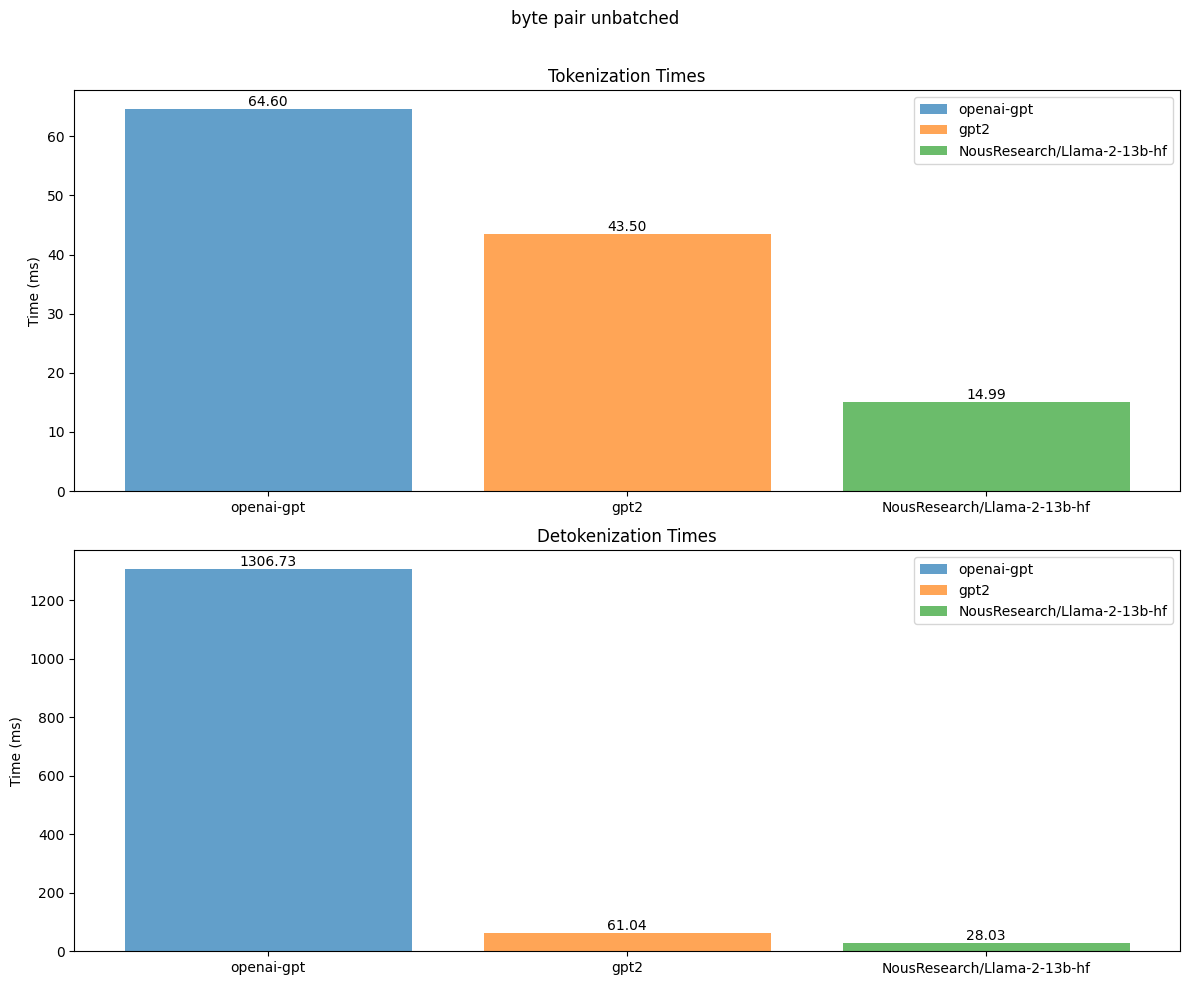

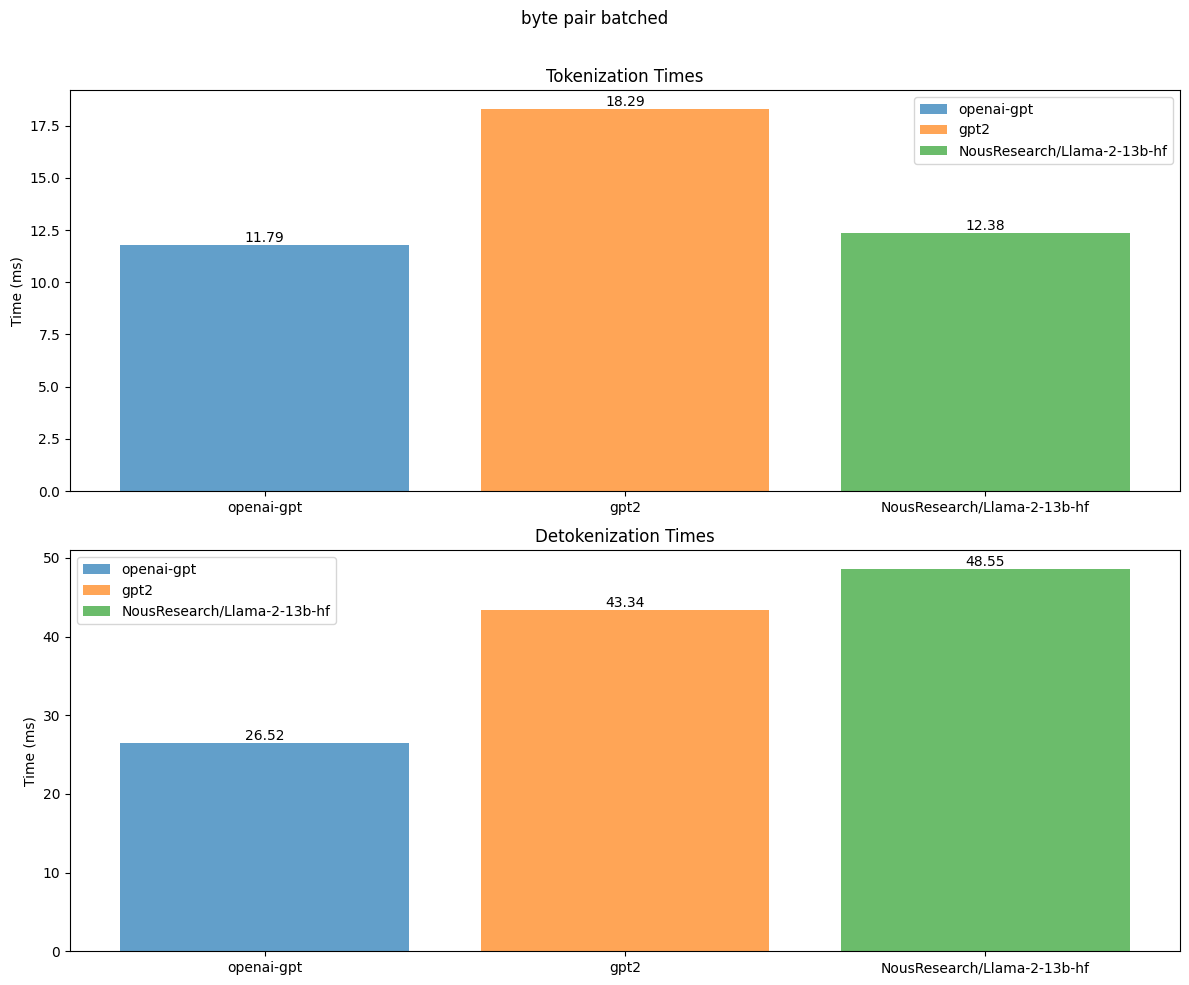

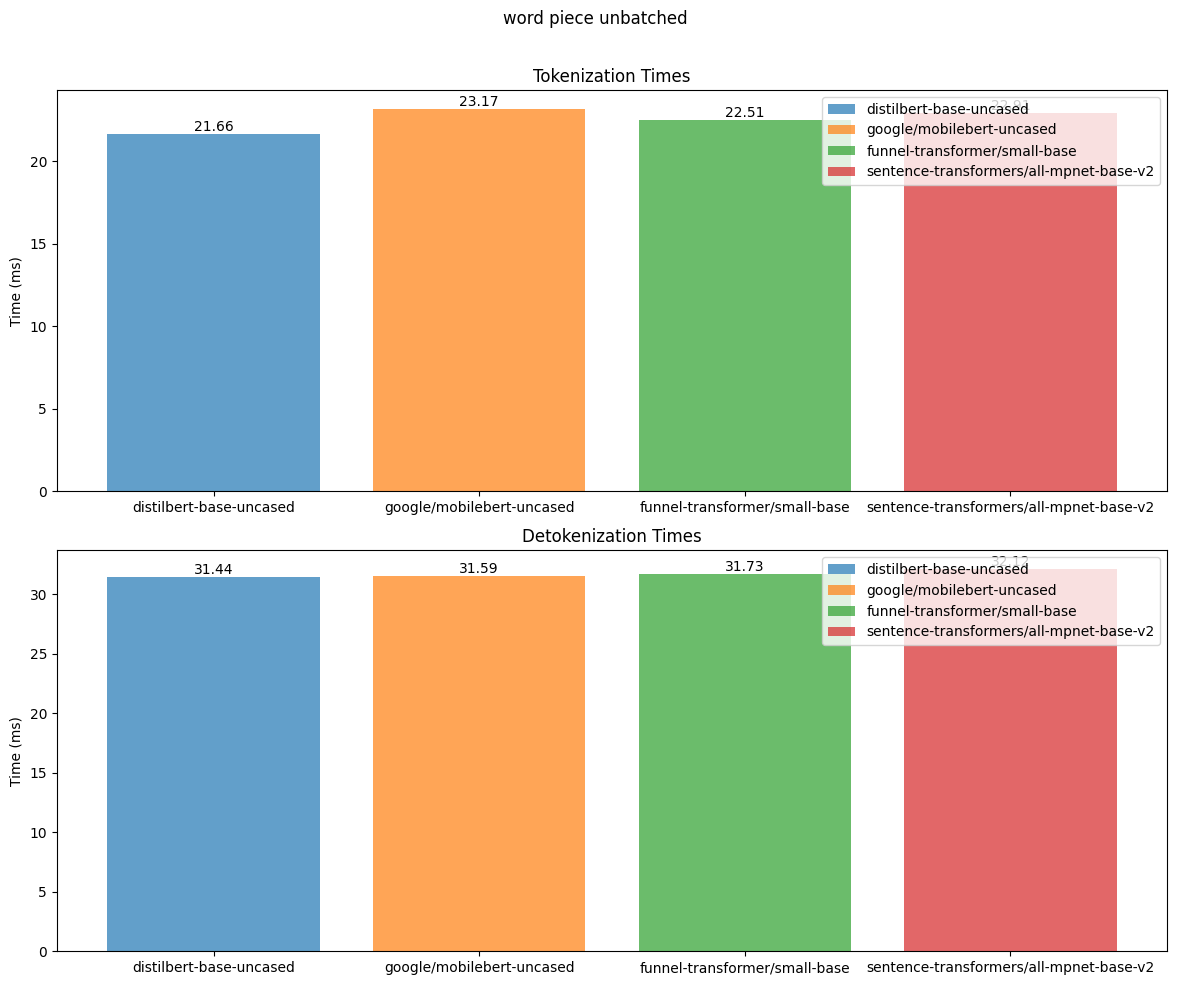

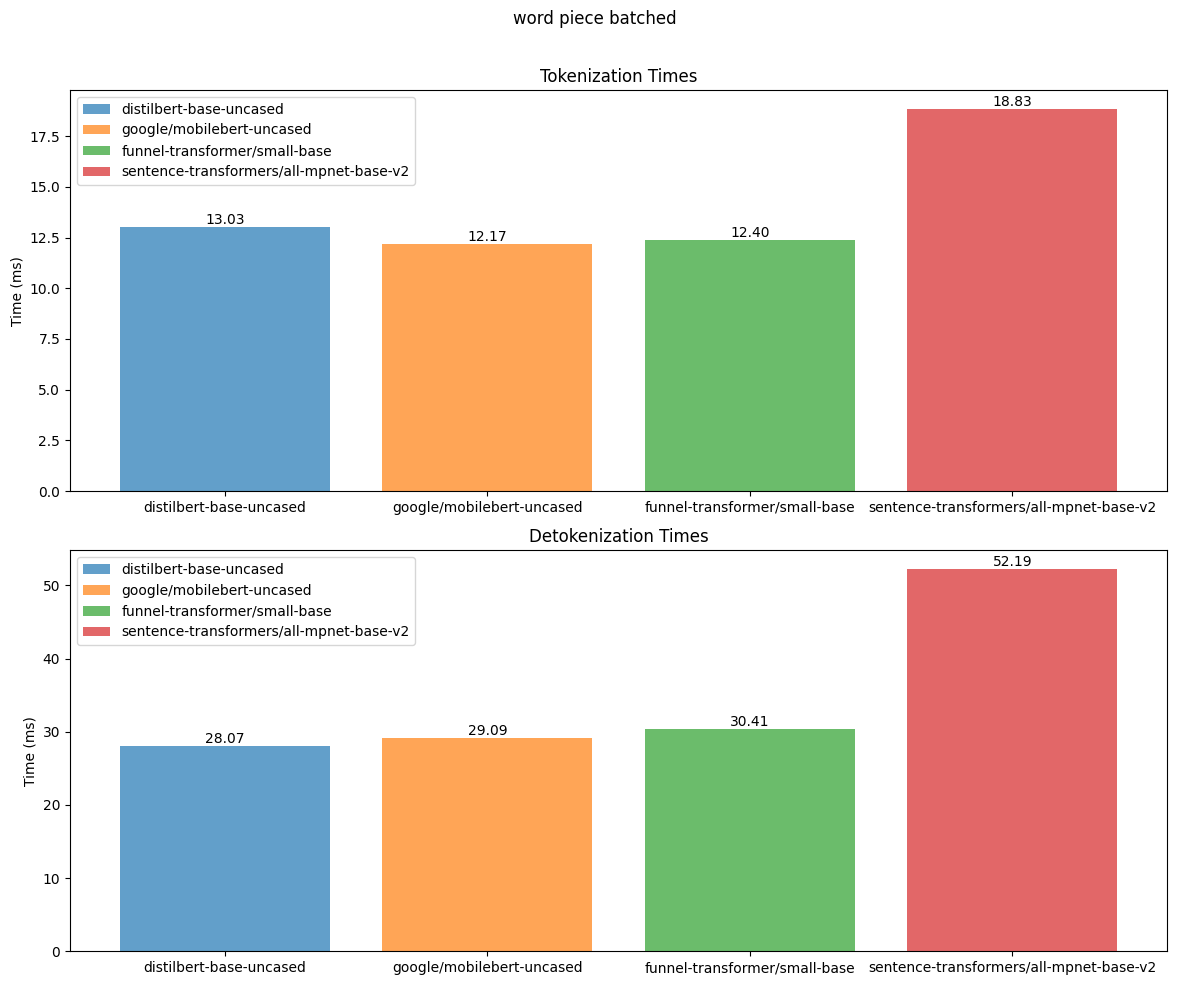

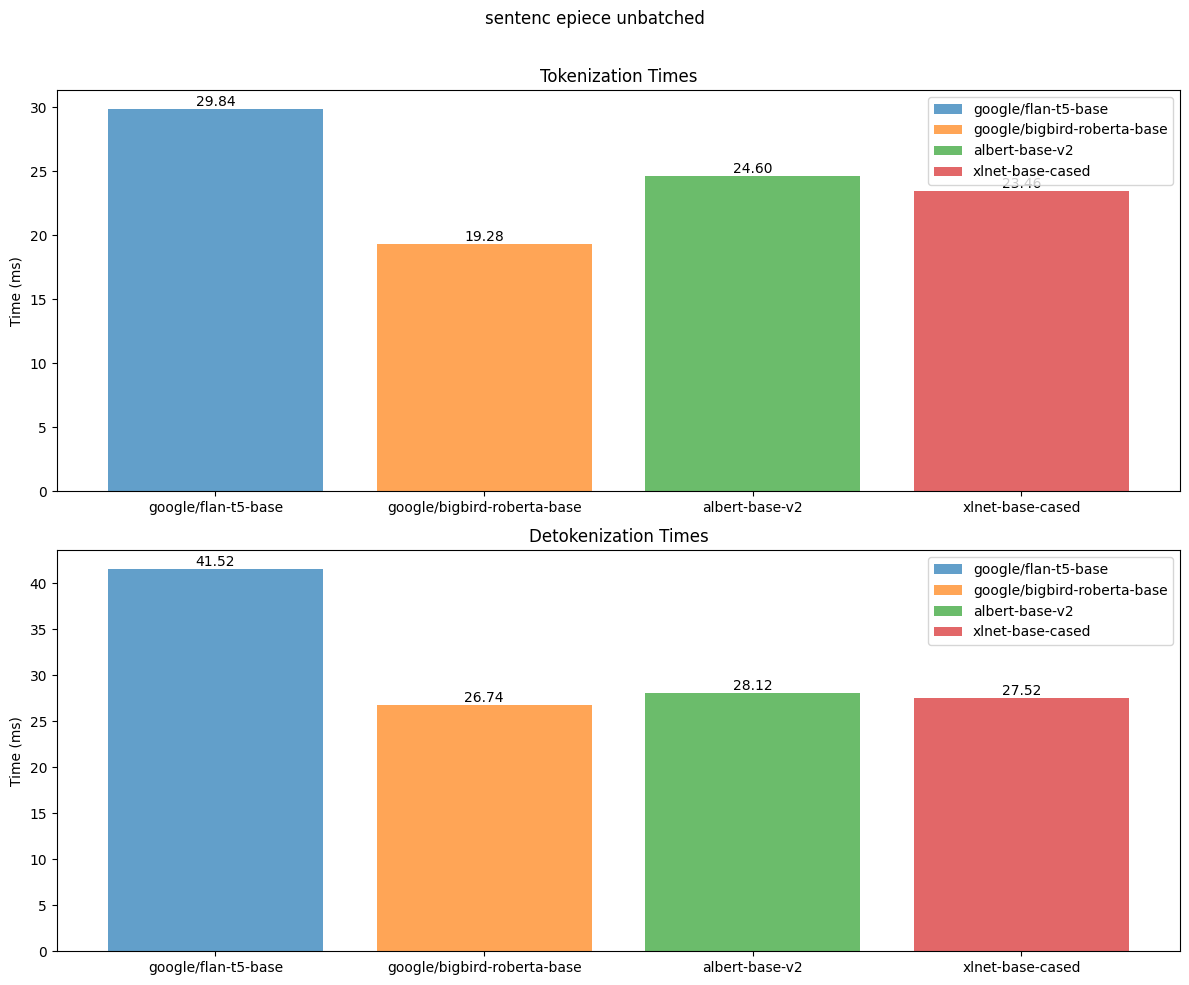

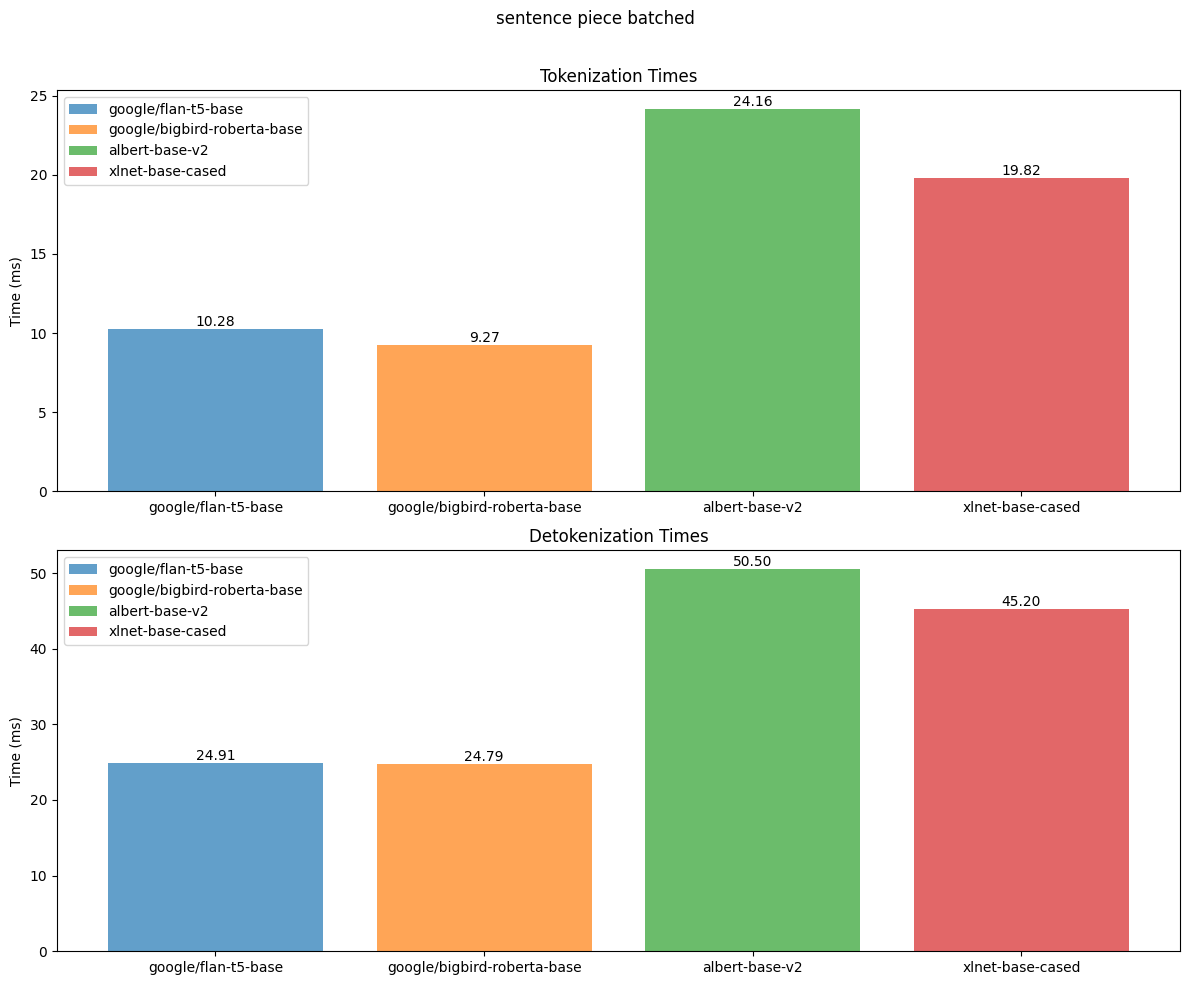

In [ ]:
import matplotlib.pyplot as plt

def plot_dict(data_dict, title=''):
    # Extract method names and labels for the x-axis
    methods = list(data_dict.keys())
    x_labels = [f"{method}" for method in methods]

    # Create subplots for tokenization and detokenization times
    fig, axs = plt.subplots(2, figsize=(12, 10))
    fig.suptitle(title)

    for key, value in data_dict.items():
        if key == "method":
            continue

        # Plot tokenization times
        tokenization_time = value.get('Tokenization', 0.0)
        axs[0].bar(key, tokenization_time, label=key, alpha=0.7)

        # Plot detokenization times
        detokenization_time = value.get('Detokenization', 0.0)
        axs[1].bar(key, detokenization_time, label=key, alpha=0.7)

        # Add text labels on top of the bars
        axs[0].annotate(f'{tokenization_time:.2f}', (key, tokenization_time),
                            ha='center', va='bottom')
        axs[1].annotate(f'{detokenization_time:.2f}', (key, detokenization_time),
                            ha='center', va='bottom')

    # Set labels and titles
    axs[0].set_ylabel('Time (ms)')
    axs[0].set_title('Tokenization Times')
    axs[0].legend()

    axs[1].set_ylabel('Time (ms)')
    axs[1].set_title('Detokenization Times')
    axs[1].legend()

    # Show the plot
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()
    print("\n\n\n\n")
plot_dict(byte_pair_timing_unbatched, "byte pair unbatched")
plot_dict(byte_pair_timing_batched, "byte pair batched")
plot_dict(word_piece_timing_unbatched, "word piece unbatched")
plot_dict(word_piece_timing_batched, "word piece batched")
plot_dict(sentence_piece_timing_unbatched, "sentenc epiece unbatched")
plot_dict(sentence_piece_timing_batched, "sentence piece batched")


### **Batched Vs Unbatched Analysis**
## **Byte-Pair Tokenization (BPE)**

According to the graph above, For most of the response times, batched data is shown to be processed much faster during tokenization and detokenization. One of the most notable differences would be the openai-gpt model where the tokenization and detokenization timing for unbatched data was 11.79ms and 64.60 ms respectively for tokenization and 26.52ms and 1306.73ms respectively for detokenization. While the batched data's processing time for tokenization and detokenization was 11.79 ms and 26.52 respectively. Batched data processing is faster than unbatched data processing for BPE due to several possible key factors. Firstly, batched data allows for efficient parallelization, enabling multiple texts to be tokenized simultaneously, which significantly reduces processing time. Next, BPE employs a shared vocabulary across the entire batch, eliminating the need to rebuild vocabularies for individual texts and enhancing its efficiency. Following that, batched processing minimizes overhead associated with initializing and maintaining tokenization processes for each text. Lastly, optimized algorithms specifically designed for batched data further contribute to the speed advantage. Collectively, these factors make batched data much faster and more efficient than unbatched data.

However, this was not the case for the detokenization of NousResearch/Llama-2-13b-hf where the batched and unbatched data processing time was 48.55 ms and 28.03 ms respectively. There could be some possible reasons for this.. Firstly, batched data may introduce complexities during the detokenization process, especially if the model's architecture is not optimized for handling batched inputs during decoding. In this case it is not certain if it was by chance or indeed the model's architecture was not optimized enough. Secondly, the batched detokenization process might require additional steps or computations to align and concatenate the outputs of multiple inputs, which can result in increased processing time. Additionally, the model's inherent characteristics and design, such as the size of its vocabulary or the decoding algorithms it employs, may not favor batched detokenization, causing it to perform better with unbatched inputs. These are just some possible reasons as to why the processing of unbatched data could be faster.



## **WordPiece Tokenization**

According to the graph above, For most of the response times, batched data is shown to be processed faster during tokenization and detokenization even though the difference in processing time is small. An example would be for google/mobilebert-uncased model, the data processing times are 12.17ms and 23.17ms for batched and unbatched data for tokenization and 29.09ms and 31.59ms respectively for batched and unbatched data for detokenization. Possible explanations for this are Firstly, batched data allows for parallelization, where multiple text sequences can be tokenized simultaneously. WordPiece tokenization, which involves breaking text into smaller subword units, can take advantage of parallel processing more efficiently, as it can tokenize multiple subwords in parallel. Next, batched data typically involves larger input sizes, and WordPiece tokenization can benefit from this by processing longer text sequences more efficiently. Additionally, WordPiece tokenization's subword-level approach may optimize batch processing, as it can process subword units in parallel and efficiently handle the complexities of large-scale input data. Overall, the combination of parallelization and the nature of subword tokenization potentially contributes to WordPiece's ability to process batched data more quickly compared to unbatched data.

However, there is an outlier for the detokenization of sentence-transformers/all-mpnet-base-v2 model where the batched and unbatched processing times are 52.19ms and 32.12ms respectively. This could just be due to chance. Other reasons could include  underlying architecture and implementation of the model. The sentence-transformers/all-mpnet-base-v2 model might be designed to optimize processing efficiency for individual text sequences, making it more efficient in handling unbatched data. When operating on batched data, the model may need to manage and synchronize multiple sequences, which could introduce overhead in terms of memory management and synchronization. This additional complexity in handling batched input may result in a slightly slower detokenization process compared to unbatched data, where the model can focus solely on a single sequence.


## **Sentence Piece Tokenization**
Following a similar trend from the 2 tokenization methods above, Sentence Piece tokenization models processes batched data faster than unbatched data. An example of this would be google/flan-t5-base model where the processing times are 10.28ms and 29.84ms  for batched and unbatched data for tokenization and 24.91ms and 41.52ms respectively for batched and unbatched data for detokenization.Some possible explanations to this could be SentencePiece processing batched data faster than unbatched data could Firstly, SentencePiece is a subword tokenization method that works on the subword level, allowing it to handle longer sequences more efficiently. When processing batched data, the model can take advantage of parallelization, distributing the workload across multiple sequences simultaneously, which can lead to faster processing times. Additionally, batched data may be structured in a way that optimizes the tokenization process, reducing the overhead of handling individual sequences. SentencePiece might have been optimized to handle batched input effectively, taking advantage of modern hardware with parallel processing capabilities. Finally, the specific implementation of SentencePiece may have incorporated efficient batch processing algorithms, further contributing to its faster performance on batched data compared to unbatched data.

However, there is an outlier for the detokenization of albert-base-v2 model where the batched and unbatched processing times are 50.50ms and 28.12ms respectively.One possible reason for this result could be related to the intricacies of the detokenization process. When working with batched data, the model needs to reverse the tokenization for multiple sequences simultaneously. This process involves identifying and concatenating subword tokens into complete words or phrases which can be more complex and time-consuming when performed in a batched manner. Unlike with unbatched data, the model only needs to detokenize a single sequence at a time, simplifying the detokenization process and potentially making it faster. Additionally, certain models and tokenization methods may not be optimized for efficient batched detokenization, leading to slower processing times in such scenarios.



## **Tokenization Technique Comparisons**

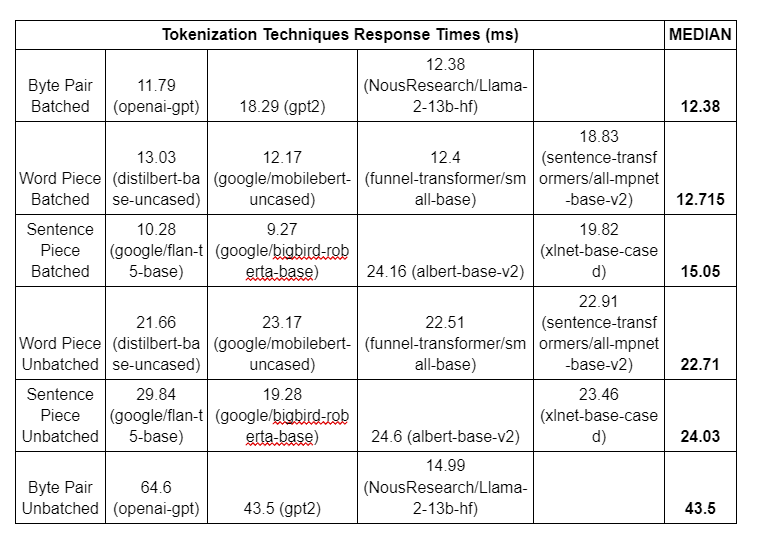

In the context of unbatched tokenization performance, a clear hierarchy emerges among the three prominent tokenization techniques. WordPiece exhibits the highest efficiency, demonstrating the quickest average response time in segmenting text into subwords or tokens. This speed showcases its aptitude for swiftly processing and organizing text. Following closely, SentencePiece displays the next level of efficiency, slightly trailing behind WordPiece in response time. SentencePiece's notable ability to handle various granularities, including subword, character, or word levels, contributes to its adaptability without sacrificing processing speed. Conversely, Byte Pair Encoding (BPE) manifests as the slowest performer among the trio in an unbatched tokenization setting. The iterative merge-based approach of BPE, where subwords or characters are combined based on statistical properties, appears to be less efficient than the strategies employed by WordPiece and SentencePiece when batching is not utilized. In terms of handling rare words effectively, both WordPiece and BPE excel, striking a balance between efficient processing and the ability to handle less frequent vocabulary. However, WordPiece particularly shines in this balance, showcasing its strength as a preferred choice when speed is a paramount factor, especially in applications where expediency is crucial. Despite its slightly longer processing time, BPE retains its value, especially for its simplicity and proficiency in handling rare words.

In the realm of batched tokenization performance, a distinct hierarchy among the three primary tokenization methods becomes evident. Byte Pair Encoding (BPE) emerges as the swiftest performer, boasting the lowest average response time in the segmentation of text into subwords or tokens. This agility underscores its efficiency in processing and organizing text when batching is employed. Following closely, WordPiece exhibits the next level of efficiency, with a slightly higher average response time compared to BPE. WordPiece's ability to adeptly handle tokenization tasks within a batched setting underscores its efficiency and responsiveness, especially when considering its fine-grained subword segmentation. Conversely, SentencePiece lags behind, manifesting as the slowest performer in batched tokenization scenarios. The comparative lag in response time for SentencePiece suggests that its flexible language modeling approach, while highly versatile and accommodating various granularities, may encounter a trade-off in terms of speed when batching is applied. In summary, BPE stands out as the optimal choice for batched tokenization, demonstrating swift and efficient processing. On the other hand, SentencePiece, while slightly slower, still retains value for its versatility and adaptability to diverse text types and languages, albeit with a compromise on speed within a batched context. The selection of the ideal tokenization method ultimately hinges on the balance between speed, flexibility, and suitability for specific application needs.


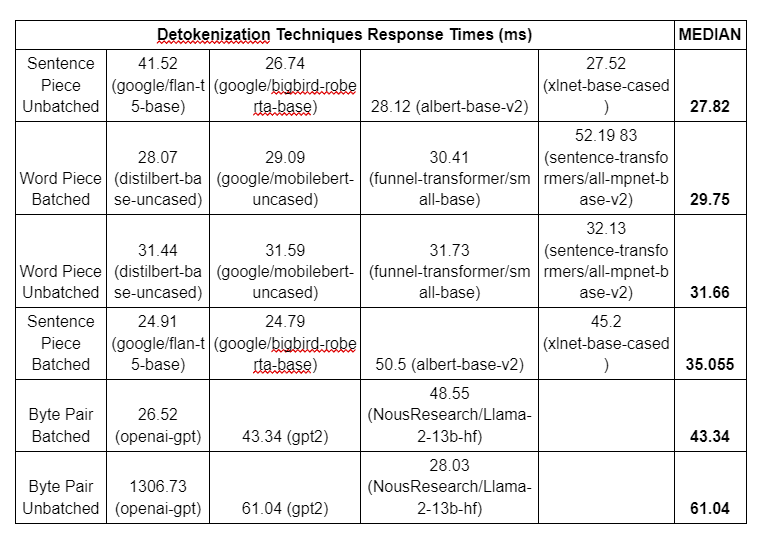

Based on our results, it is evident that Sentence Piece Unbatched stands out as the most efficient tokenization technique in terms of response time. It showcases an impressive ability to quickly process and segment text into subwords or tokens without the need for batching, making it ideal for real-time or time-sensitive applications. Following closely, Word Piece, whether in a batched or unbatched setup, proves to be highly efficient as well. The batched approach offers a streamlined tokenization process, while even in an unbatched context, Word Piece demonstrates noteworthy speed and effectiveness. On the other end of the spectrum, Byte Pair Unbatched exhibits the slowest response time among the techniques we tested. The iterative merging approach of Byte Pair Encoding (BPE) seems to be less efficient when not utilizing batching, resulting in longer processing times. These findings shed light on the trade-offs between different tokenization methods, emphasizing the need to consider both efficiency and batching strategies in selecting the most appropriate approach based on specific use cases and performance requirements.


##Translation of corpus

In [ ]:
from transformers import M2M100ForConditionalGeneration, AutoTokenizer

def translate(corpus,language):
    # Load the pre-trained model and tokenizer
    tokenizer = AutoTokenizer.from_pretrained("facebook/m2m100_418M", src_lang="en")
    model = M2M100ForConditionalGeneration.from_pretrained("facebook/m2m100_418M")

    # Initialize an empty list to store the translated sentences
    translated_corpus = []

    # Loop through each sentence in the input corpus
    for sentence in corpus:
        # Tokenize and encode the English sentence
        encoded_en = tokenizer(sentence, return_tensors="pt")

        # Generate the translation to Chinese
        generated_tokens = model.generate(**encoded_en, forced_bos_token_id=tokenizer.get_lang_id(language))

        # Decode the generated tokens back to text
        translated_sentence = tokenizer.decode(generated_tokens[0], skip_special_tokens=True)

        #Print translated_sentence
        print(translated_sentence)

        # Append the translated sentence to the result list
        translated_corpus.append(translated_sentence)

    return translated_corpus


In [ ]:
chinese_corpus = translate(corpus2,"zh")
# Save the translations to a text file
with open("corpus_2_chinese.txt", "w", encoding="utf-8") as file:
    for translation in chinese_corpus:
        file.write(translation + "\n")

print("Translations saved to 'corpus_2_chinese.txt'.")

KeyboardInterrupt: ignored

# Additional Analysis - Translation Accuracy Analysis

## Overview

We investigated the accuracy of translations using the facebook/m2m100_418M multilingual model. We evaluate the quality of translations from English to Chinese and Spanish, followed by a retranslation of the generated Chinese and Spanish corpora back to English. The accuracy of these retranslations is determined using the Bilingual Evaluation Understudy (BLEU) Score, a common metric for assessing machine translation quality.

## Workflow

### 1. Translation to Chinese and Spanish
   - We leverage the facebook/m2m100_418M model to translate an English corpus into both Chinese and Spanish. This step results in translated corpora in these target languages.

### 2. Retranslation to English
   - The translated Chinese and Spanish corpora are then retranslated back into English using the same facebook/m2m100_418M model. This process generates retranslated English corpora, which should ideally match the original English text.

### 3. Accuracy Assessment with Cosine Similarity
- To further evaluate the accuracy of the translations and retranslations, we employed cosine similarity as an additional metric. Cosine similarity measures the similarity between two text corpora by comparing the vector representations of the text. In our case, we'll compare the original English corpus with the retranslated English corpus using cosine similarity.

#### Workflow
Vectorization: We transformed both the original English corpus and the retranslated English corpus into numerical vector representations. This vectorization can be performed using techniques such as TF-IDF or word embeddings.

Cosine Similarity Calculation: We computed the cosine similarity score between the vector representations of the original English corpus and the retranslated English corpus. This score ranges from -1 (completely dissimilar) to 1 (identical). A higher cosine similarity score indicates a higher degree of similarity between the two corpora.

Thresholds for Accuracy:

A cosine similarity score close to 1 suggests a high level of accuracy, as it indicates that the retranslated corpus closely matches the original English text.
Lower cosine similarity scores may indicate inaccuracies or deviations in the retranslation.

## Results
TBC

In [6]:
import os

def text_to_corpus_list(path:str) -> list:
    """Converts a corpus in .txt format to a list of lines"""
    with open(path, "r", encoding="utf-8") as file:
        corpus = []
        for line in file.readlines():
            corpus.append(line.strip())  # Remove newline characters if needed
        return corpus  # Return the list of lines

def retranslate_to_eng(translated_corpus, lang_code:str, output_path:str):
    """Retranslates a corpus to english."""
    retranslated_corpus = translate(translated_corpus, "en")
    with open(output_path, "w", encoding="utf-8") as file:
        for line in retranslated_corpus:
          file.write(line + "\n")

# # Initialize file paths
# base_path = os.path.join("ICT3102-e-mc2-assignment-1", "Datasets") # Replace with where your translated corpora exists.
# chinese_corpus1_path = os.path.join(base_path, "corpus_1_chinese.txt")
# espanol_corpus1_path = os.path.join(base_path, "corpus_1_espanol.txt")
# chinese_corpus2_path = os.path.join(base_path, "corpus_2_chinese.txt")
# espanol_corpus2_path = os.path.join(base_path, "corpus_2_espanol.txt")

# output_path = os.path.join(base_path, "retranslated_corpus_2_espanol.txt") # CHANGE THIS
# corpus_to_retranslate = text_to_corpus_list(espanol_corpus2_path) # CHANGE THIS

# retranslate_to_eng(corpus_to_retranslate, "en", output_path)

In [3]:
import spacy
import os
from sklearn.metrics.pairwise import cosine_similarity

In [7]:
def update_similarity_dictionary(similarity: dict, cosine_similarity_score: float) -> dict:
    """Populates the similarity quality dictionary"""
    # Categorize based on cosine similarity score ranges
    if cosine_similarity_score >= 0.8:
        similarity["High Similarity"] += 1  # High similarity category (score >= 0.8)
    elif cosine_similarity_score >= 0.6:
        similarity["Moderate Similarity"] += 1  # Moderate similarity category (0.6 <= score < 0.8)
    elif cosine_similarity_score >= 0.4:
        similarity["Low Similarity"] += 1  # Low similarity category (0.4 <= score < 0.6)
    else:
        similarity["Very Low Similarity"] += 1  # Very low similarity category (score < 0.4)

# Calculate cosine similarity
def calculate_cosine_similarity(original, translated) -> float:
    # Convert tokens to lowercase for consistent comparison
    # Load the spaCy model
    tokens1 = [token.text for token in nlp(original) if not token.is_stop]
    tokens2 = [token.text for token in nlp(translated) if not token.is_stop]

    tokens1 = [token.lower() for token in tokens1]
    tokens2 = [token.lower() for token in tokens2]

    # Combine tokens into one list for vectorization
    combined_tokens = tokens1 + tokens2

    # Create vectors for each sentence
    vector1 = [1 if token in tokens1 else 0 for token in combined_tokens]
    vector2 = [1 if token in tokens2 else 0 for token in combined_tokens]

    # Calculate cosine similarity
    similarity_score = cosine_similarity([vector1], [vector2])[0][0]
    return similarity_score

def analyze_similarity(original_corpus_path:str, retranslated_corpus_path:str) -> dict:
  similarity = {
    "High Similarity": 0,        # Cosine Similarity >= 0.8
    "Moderate Similarity": 0,    # 0.6 <= Cosine Similarity < 0.8
    "Low Similarity": 0,         # 0.4 <= Cosine Similarity < 0.6
    "Very Low Similarity": 0     # Cosine Similarity < 0.4
  }

  print(f"Comparing similarity between {os.path.basename(original_corpus_path)} and {os.path.basename(retranslated_corpus_path)}")
  original_corpus = text_to_corpus_list(original_corpus_path) # retrieve the original corpus as a list of lines
  retranslated_corpus = text_to_corpus_list(retranslated_corpus_path) # retrieve the translated corpus as a list of lines
  while (1):
    if len(original_corpus) == 0 or len(retranslated_corpus) == 0:
      break

    original = original_corpus.pop()
    retranslated = retranslated_corpus.pop()

    # Compare the original text, updat the transaction_quality dictionary using the bleu score
    similarity_score = calculate_cosine_similarity(original, retranslated)
    update_similarity_dictionary(similarity, similarity_score)
  print(f"Similarity analysis: {similarity}")
  return similarity

nlp = spacy.load("en_core_web_sm")
base_path = "."
# Setting up Corpus 1 analysis
original_corpus_1_path = os.path.join(base_path, "original_corpus_1.txt")
retranslated_chinese_corpus_path = os.path.join(base_path, "retranslated_corpus_1_chinese.txt")
retranslated_espanol_corpus_path = os.path.join(base_path, "retranslated_corpus_1_espanol.txt")
# Generating Corpus 1 similarity scores
corpus_1_similarity_chinese = analyze_similarity(original_corpus_1_path, retranslated_chinese_corpus_path)
corpus_1_similarity_espanol  = analyze_similarity(original_corpus_1_path, retranslated_espanol_corpus_path)

# Setting up Corpus 2 analysis
original_corpus_2_path = os.path.join(base_path, "original_corpus_2.txt")
retranslated_chinese_corpus_path = os.path.join(base_path, "retranslated_corpus_2_chinese.txt")
retranslated_espanol_corpus_path = os.path.join(base_path, "retranslated_corpus_2_espanol.txt")
# Generating Corpus 2 similarity scores
corpus_2_similarity_chinese = analyze_similarity(original_corpus_2_path, retranslated_chinese_corpus_path)
corpus_2_similarity_espanol = analyze_similarity(original_corpus_2_path, retranslated_espanol_corpus_path)


Comparing similarity between original_corpus_1.txt and retranslated_corpus_1_chinese.txt
Similarity analysis: {'High Similarity': 101, 'Moderate Similarity': 52, 'Low Similarity': 21, 'Very Low Similarity': 1}
Comparing similarity between original_corpus_1.txt and retranslated_corpus_1_espanol.txt
Similarity analysis: {'High Similarity': 64, 'Moderate Similarity': 34, 'Low Similarity': 37, 'Very Low Similarity': 40}
Comparing similarity between original_corpus_2.txt and retranslated_corpus_2_chinese.txt
Similarity analysis: {'High Similarity': 61, 'Moderate Similarity': 87, 'Low Similarity': 4, 'Very Low Similarity': 1}
Comparing similarity between original_corpus_2.txt and retranslated_corpus_2_espanol.txt
Similarity analysis: {'High Similarity': 0, 'Moderate Similarity': 7, 'Low Similarity': 43, 'Very Low Similarity': 103}


# Visualizing Accuracy

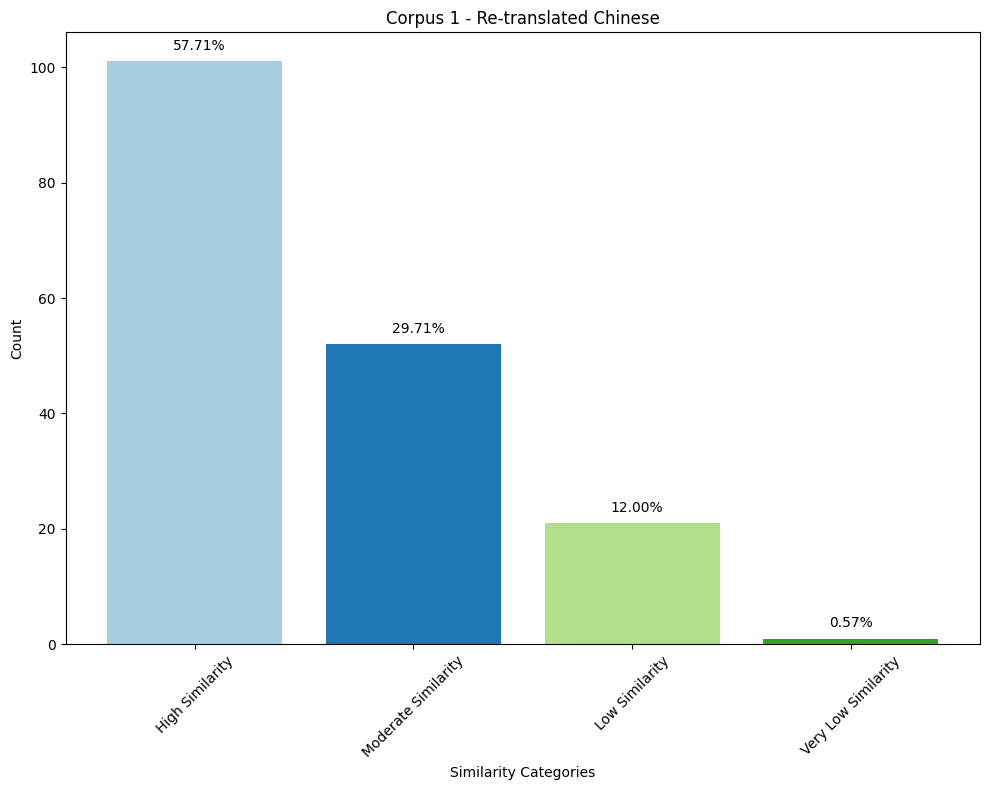

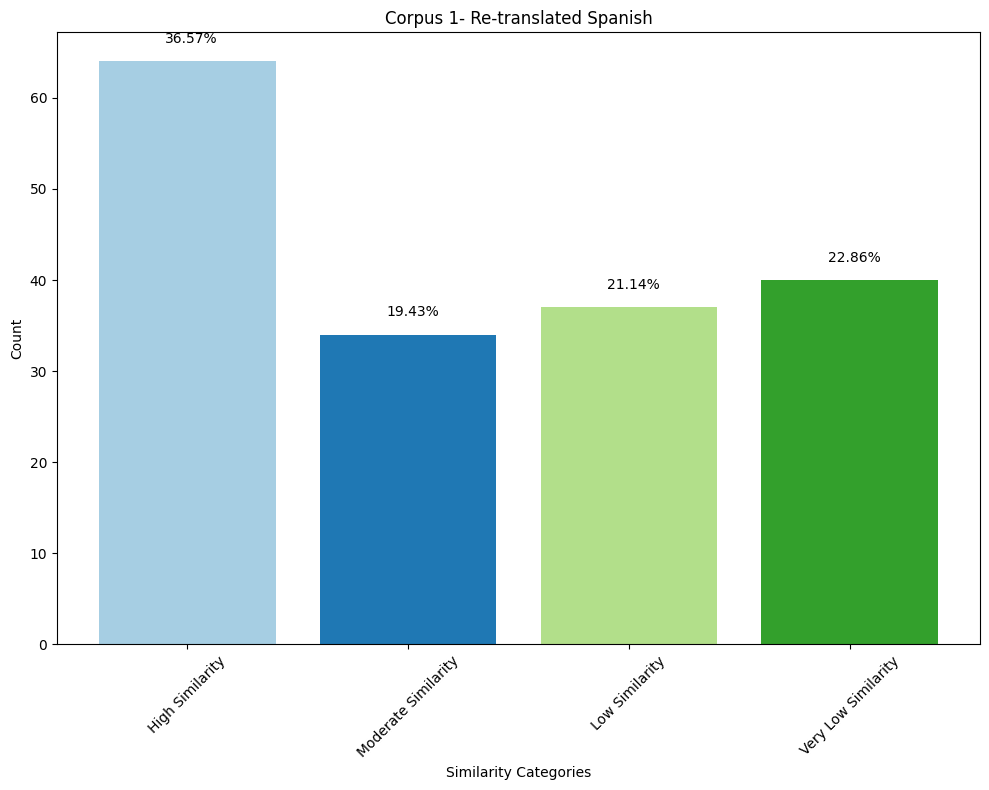

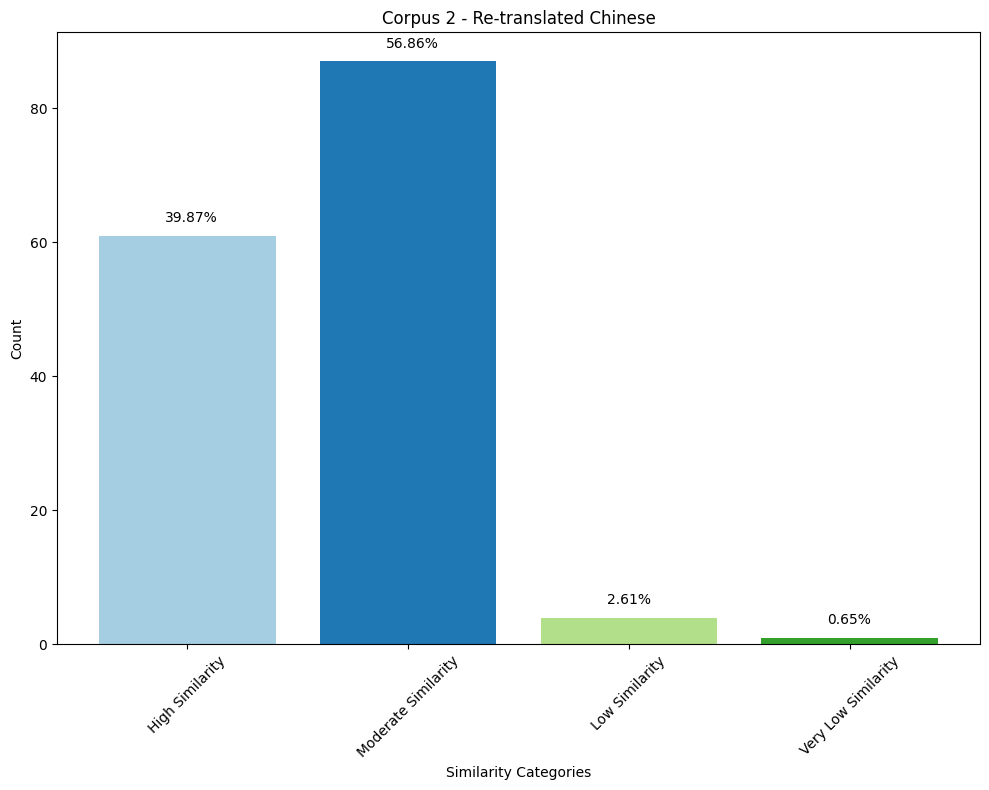

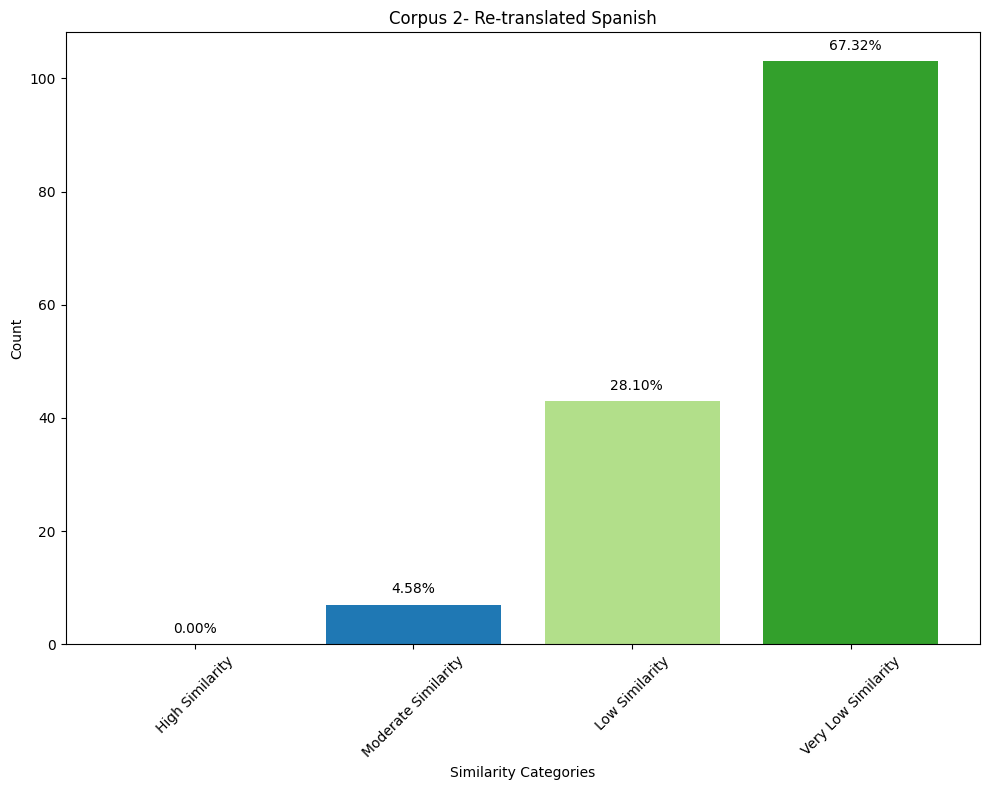

In [8]:
import matplotlib.pyplot as plt

def plot_similarity(similarity_dict, title):
    """Plot similarity data from a given dictionary.

    Args:
        similarity_dict (dict): A dictionary containing similarity category counts.
        title (str): The title for the bar chart.
    """
    # Data
    categories = list(similarity_dict.keys())
    counts = list(similarity_dict.values())

    # Create a color map with unique colors for each bar
    colors = plt.cm.Paired(range(len(categories)))

    # Create the bar chart
    plt.figure(figsize=(10, 8))
    bars = plt.bar(categories, counts, color=colors)
    plt.title(title)
    plt.ylabel('Count')
    plt.xlabel('Similarity Categories')
    plt.xticks(rotation=45)  # Rotate x-axis labels for readability

    # Add percentage labels on top of each bar
    total_counts = sum(counts)
    for bar, count in zip(bars, counts):
        percentage = (count / total_counts) * 100
        plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 2, f'{percentage:.2f}%', fontsize=10)

    # Show the plot
    plt.tight_layout()
    plt.show()
    print("\n")
plot_similarity(corpus_1_similarity_chinese, "Corpus 1 - Re-translated Chinese")
plot_similarity(corpus_1_similarity_espanol, "Corpus 1- Re-translated Spanish")


plot_similarity(corpus_2_similarity_chinese, "Corpus 2 - Re-translated Chinese")
plot_similarity(corpus_2_similarity_espanol, "Corpus 2- Re-translated Spanish")

##Other languages

In [ ]:
def read_from_file(name):
  # Open the file for reading
  with open(name, 'r') as file:
      # Read all lines from the file and store them in a list
      lines = [line.strip() for line in file]
      return lines

!gdown 1PflB7C7BHccK47KKRUbRW1wR4OSMUxXO #downloading corpus_1_chinese.txt
!gdown 1cH4k1NSNnSImSJMqV7WUeINW-BIv8Sl_ #downloading corpus_1_espanol.txt
!gdown 1A4JOVzqk8houWPbMp6YbRm1dsSlYyLVM #downloading corpus_2_chinese.txt
!gdown 1z6sSljlNvOmvcYVK9lYg9OcyAvjkVvRp #downloading corpus_2_espanol.txt
zh1_array = read_from_file("corpus_1_chinese.txt")
zh2_array = read_from_file("corpus_2_chinese.txt")
es1_array = read_from_file("corpus_1_espanol.txt")
es2_array = read_from_file("corpus_2_espanol.txt")

chinese_models = ["bert-base-chinese", "bert-base-multilingual-cased", "OpenBuddy/openbuddy-llama2-70b-v10.1-bf16", "distilbert-base-multilingual-cased", "xlm-roberta-base"]
spanish_models = ["bert-base-multilingual-cased", "distilbert-base-multilingual-cased", "xlm-roberta-base"]
english_models = ["bert-base-multilingual-cased", "OpenBuddy/openbuddy-llama2-70b-v10.1-bf16", "distilbert-base-multilingual-cased", "xlm-roberta-base","bert-base-multilingual-cased", "distilbert-base-multilingual-cased", "xlm-roberta-base"]

Downloading...
From: https://drive.google.com/uc?id=1PflB7C7BHccK47KKRUbRW1wR4OSMUxXO
To: /content/corpus_1_chinese.txt
100% 11.3k/11.3k [00:00<00:00, 25.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1cH4k1NSNnSImSJMqV7WUeINW-BIv8Sl_
To: /content/corpus_1_espanol.txt
100% 14.2k/14.2k [00:00<00:00, 38.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1A4JOVzqk8houWPbMp6YbRm1dsSlYyLVM
To: /content/corpus_2_chinese.txt
100% 48.5k/48.5k [00:00<00:00, 90.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1z6sSljlNvOmvcYVK9lYg9OcyAvjkVvRp
To: /content/corpus_2_espanol.txt
100% 74.6k/74.6k [00:00<00:00, 84.3MB/s]


## English Tokenization and Detokenization

In [ ]:
print("--------------------------Unbatched English Corpus 1 Data-------------------------------")
english_corpus1_timing_unbatched = analyse_encode_plus(english_models, corpus, 10)
print("--------------------------Batched English Corpus 1 Data-------------------------------")
english_corpus1_timing_batched = analyse_batch(english_models,corpus, 10)
print("--------------------------Unbatched English Corpus 2 Data-------------------------------")
english_corpus2_timing_unbatched = analyse_encode_plus(english_models, corpus2,10)
print("--------------------------Batched English Corpus 2 Data-------------------------------")
english_corpus2_timing_batched = analyse_batch(english_models,corpus2,10)

--------------------------Unbatched English Corpus 1 Data-------------------------------


bert-base-multilingual-cased:
Average Tokenization Time: 20.479726791381836 ms
Average Detokenization Time: 660.3830337524414 ms


OpenBuddy/openbuddy-llama2-70b-v10.1-bf16:
Average Tokenization Time: 15.311455726623535 ms
Average Detokenization Time: 29.256629943847656 ms


distilbert-base-multilingual-cased:
Average Tokenization Time: 20.1723575592041 ms
Average Detokenization Time: 34.787535667419434 ms


xlm-roberta-base:
Average Tokenization Time: 20.318055152893066 ms
Average Detokenization Time: 28.986573219299316 ms
bert-base-multilingual-cased:
Average Tokenization Time: 20.635271072387695 ms
Average Detokenization Time: 34.213852882385254 ms
distilbert-base-multilingual-cased:
Average Tokenization Time: 19.99528408050537 ms
Average Detokenization Time: 34.50448513031006 ms
xlm-roberta-base:
Average Tokenization Time: 33.85822772979736 ms
Average Detokenization Time: 54.506564140319824 ms
--------------------------Batched English Corpus 1 Data-------------------------------
bert-base-multilingual-cased:
Average Tokenization Time: 19.261860847473145 ms
Average Detokenization Time: 56.250643730163574 ms
OpenBuddy/openbuddy-llama2-70b-v10.1-bf16:
Average Tokenization Time: 11.909914016723633 ms
Average Detokenization Time: 46.746230125427246 ms
distilbert-base-multilingual-cased:
Average Tokenization Time: 18.430566787719727 ms
Average Detokenization Time: 55.72712421417236 ms
xlm-ro

##Chinese Tokenization and Detokenization

In [ ]:
print("--------------------------Unbatched Chinese Corpus 1 Data-------------------------------")
chinese_corpus1_timing_unbatched = analyse_encode_plus(chinese_models, zh1_array, 10)
print("--------------------------Batched Chinese Corpus 1 Data-------------------------------")
chinese_corpus1_timing_batched = analyse_batch(chinese_models,zh1_array, 10)
print("--------------------------Unbatched Chinese Corpus 2 Data-------------------------------")
chinese_corpus2_timing_unbatched = analyse_encode_plus(chinese_models, zh2_array,10)
print("--------------------------Batched Chinese Corpus 2 Data-------------------------------")
chinese_corpus2_timing_batched = analyse_batch(chinese_models,zh2_array,10)

--------------------------Unbatched Chinese Corpus 1 Data-------------------------------


bert-base-chinese:
Average Tokenization Time: 32.804298400878906 ms
Average Detokenization Time: 67.20151901245117 ms
bert-base-multilingual-cased:
Average Tokenization Time: 35.607123374938965 ms
Average Detokenization Time: 71.89910411834717 ms
OpenBuddy/openbuddy-llama2-70b-v10.1-bf16:
Average Tokenization Time: 25.21958351135254 ms
Average Detokenization Time: 61.513304710388184 ms
distilbert-base-multilingual-cased:
Average Tokenization Time: 39.18113708496094 ms
Average Detokenization Time: 69.64976787567139 ms
xlm-roberta-base:
Average Tokenization Time: 18.37599277496338 ms
Average Detokenization Time: 33.90681743621826 ms
--------------------------Batched Chinese Corpus 1 Data-------------------------------
bert-base-chinese:
Average Tokenization Time: 20.55659294128418 ms
Average Detokenization Time: 70.29263973236084 ms
bert-base-multilingual-cased:
Average Tokenization Time: 20.760107040405273 ms
Average Detokenization Time: 67.42639541625977 ms
OpenBuddy/openbuddy-llama2-7

## Unbatched Chinese Corpus 1 Data Graph Analysis

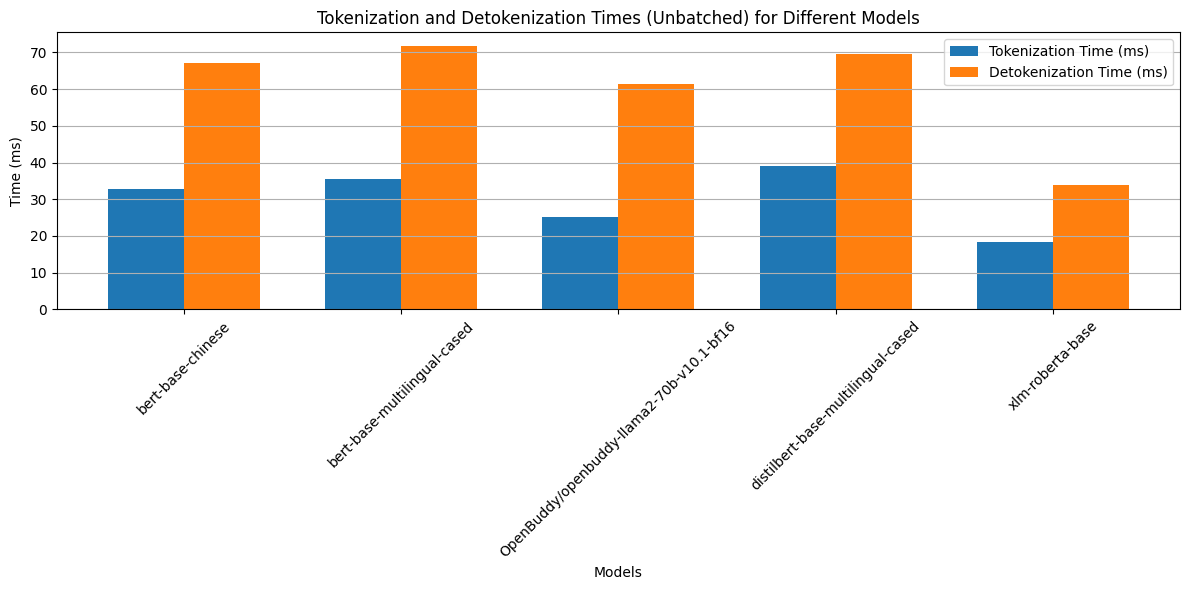

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data
models = [
    'bert-base-chinese',
    'bert-base-multilingual-cased',
    'OpenBuddy/openbuddy-llama2-70b-v10.1-bf16',
    'distilbert-base-multilingual-cased',
    'xlm-roberta-base'
]

tokenization_times = [
    chinese_corpus1_timing_unbatched[model]['Tokenization'] for model in models
]

detokenization_times = [
    chinese_corpus1_timing_unbatched[model]['Detokenization'] for model in models
]

# Set the width of the bars
bar_width = 0.35
index = np.arange(len(models))

# Create bar chart
plt.figure(figsize=(12, 6))
plt.bar(index - bar_width/2, tokenization_times, bar_width, label='Tokenization Time (ms)')
plt.bar(index + bar_width/2, detokenization_times, bar_width, label='Detokenization Time (ms)')
plt.xlabel('Models')
plt.ylabel('Time (ms)')
plt.title('Tokenization and Detokenization Times (Unbatched) for Different Models')
plt.xticks(index, models, rotation=45)
plt.grid(axis='y')
plt.legend()
plt.tight_layout()

# Show the chart
plt.show()


## Batched Chinese Corpus 1 Graph Analysis(Bar Chart)

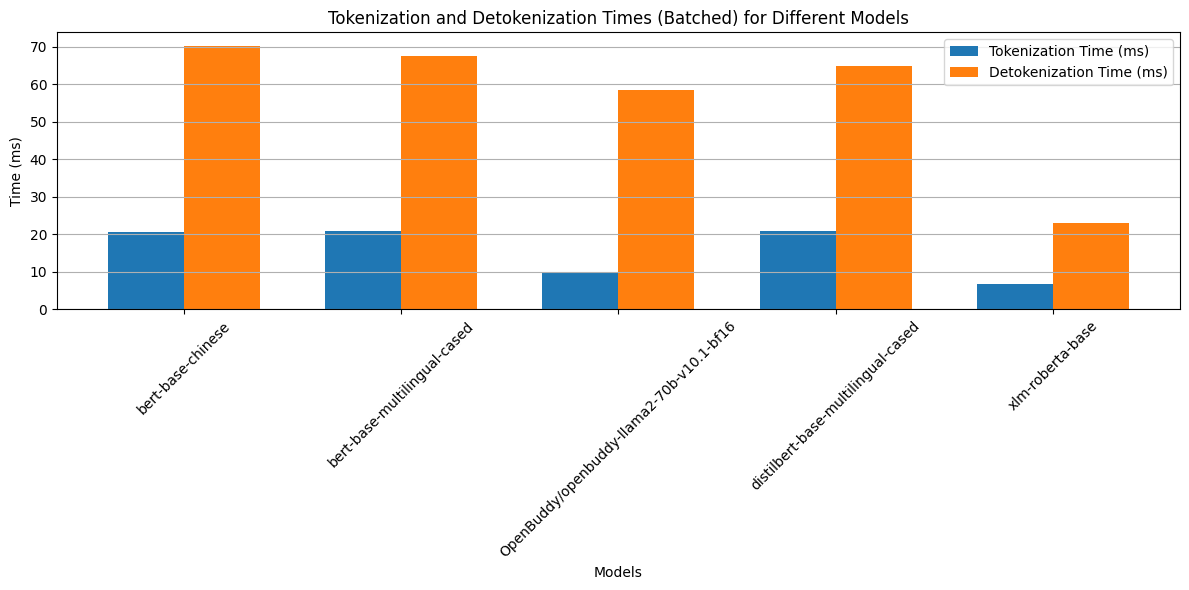

In [ ]:

# Data
models = [
    'bert-base-chinese',
    'bert-base-multilingual-cased',
    'OpenBuddy/openbuddy-llama2-70b-v10.1-bf16',
    'distilbert-base-multilingual-cased',
    'xlm-roberta-base'
]

tokenization_times = [
    chinese_corpus1_timing_batched[model]['Tokenization'] for model in models
]

detokenization_times = [
    chinese_corpus1_timing_batched[model]['Detokenization'] for model in models
]

# Set the width of the bars
bar_width = 0.35
index = np.arange(len(models))

# Create bar chart
plt.figure(figsize=(12, 6))
plt.bar(index - bar_width/2, tokenization_times, bar_width, label='Tokenization Time (ms)')
plt.bar(index + bar_width/2, detokenization_times, bar_width, label='Detokenization Time (ms)')
plt.xlabel('Models')
plt.ylabel('Time (ms)')
plt.title('Tokenization and Detokenization Times (Batched) for Different Models')
plt.xticks(index, models, rotation=45)
plt.grid(axis='y')
plt.legend()
plt.tight_layout()

# Show the chart
plt.show()


## Graph Analysis For Chinese Corpus 2 batched

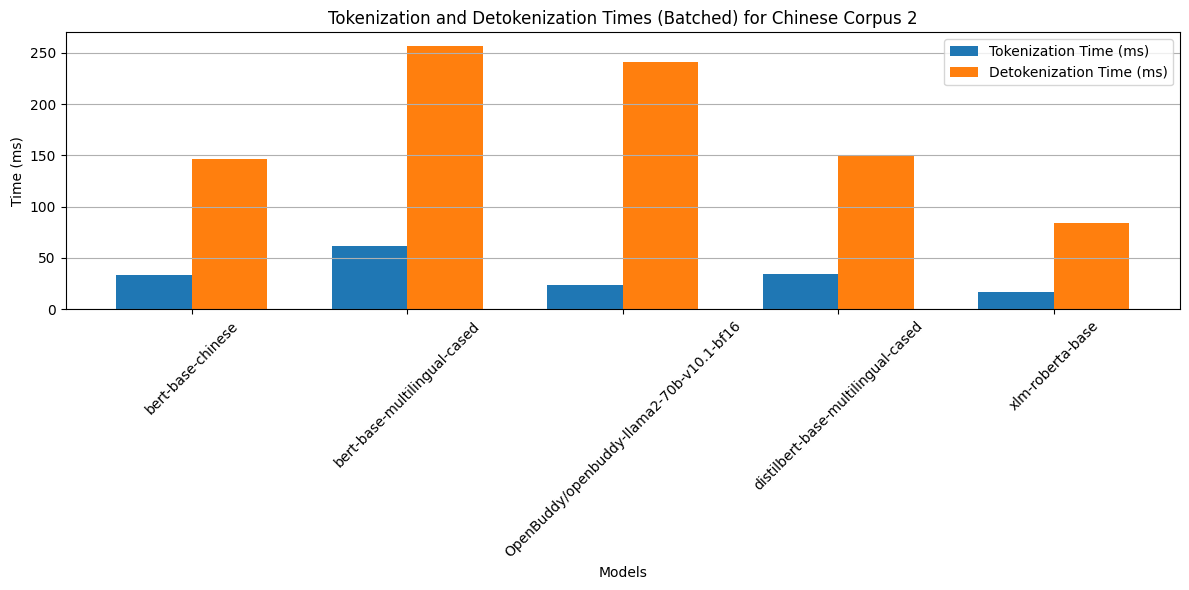

In [ ]:

# Data for chinese_corpus2_timing_batched
models = [
    'bert-base-chinese',
    'bert-base-multilingual-cased',
    'OpenBuddy/openbuddy-llama2-70b-v10.1-bf16',
    'distilbert-base-multilingual-cased',
    'xlm-roberta-base'
]

tokenization_times_batched = [
    chinese_corpus2_timing_batched[model]['Tokenization'] for model in models
]

detokenization_times_batched = [
    chinese_corpus2_timing_batched[model]['Detokenization'] for model in models
]

# Set the width of the bars
bar_width = 0.35
index = np.arange(len(models))

# Create bar chart for chinese_corpus2_timing_batched
plt.figure(figsize=(12, 6))
plt.bar(index - bar_width/2, tokenization_times_batched, bar_width, label='Tokenization Time (ms)')
plt.bar(index + bar_width/2, detokenization_times_batched, bar_width, label='Detokenization Time (ms)')
plt.xlabel('Models')
plt.ylabel('Time (ms)')
plt.title('Tokenization and Detokenization Times (Batched) for Chinese Corpus 2')
plt.xticks(index, models, rotation=45)
plt.grid(axis='y')
plt.legend()
plt.tight_layout()

# Show the chart
plt.show()


## Graph Analysis For Chinese Corpus 2 Unbatched

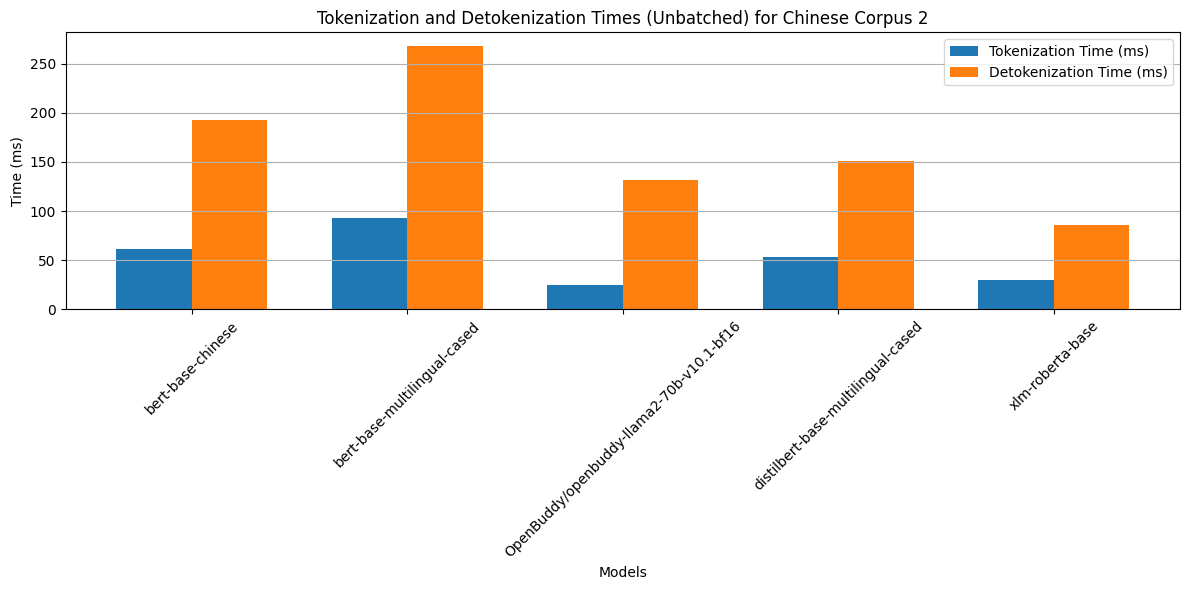

In [ ]:
# Data for chinese_corpus2_timing_unbatched
models = [
    'bert-base-chinese',
    'bert-base-multilingual-cased',
    'OpenBuddy/openbuddy-llama2-70b-v10.1-bf16',
    'distilbert-base-multilingual-cased',
    'xlm-roberta-base'
]

tokenization_times_unbatched = [
    chinese_corpus2_timing_unbatched[model]['Tokenization'] for model in models
]

detokenization_times_unbatched = [
    chinese_corpus2_timing_unbatched[model]['Detokenization'] for model in models
]

# Set the width of the bars
bar_width = 0.35
index = np.arange(len(models))

# Create bar chart for chinese_corpus2_timing_unbatched
plt.figure(figsize=(12, 6))
plt.bar(index - bar_width/2, tokenization_times_unbatched, bar_width, label='Tokenization Time (ms)')
plt.bar(index + bar_width/2, detokenization_times_unbatched, bar_width, label='Detokenization Time (ms)')
plt.xlabel('Models')
plt.ylabel('Time (ms)')
plt.title('Tokenization and Detokenization Times (Unbatched) for Chinese Corpus 2')
plt.xticks(index, models, rotation=45)
plt.grid(axis='y')
plt.legend()
plt.tight_layout()

# Show the chart
plt.show()


##Spanish Tokenization and Detokenization

In [ ]:
print("--------------------------Unbatched Spanish Corpus 1 Data-------------------------------")
spanish_corpus1_timing_unbatched = analyse_encode_plus(spanish_models, es1_array , 10)
print(spanish_corpus1_timing_unbatched)
print("--------------------------Batched Spanish Corpus 1 Data-------------------------------")
spanish_corpus1_timing_batched = analyse_batch(spanish_models,es1_array, 10)
print("--------------------------Unbatched Spanish Corpus 2 Data-------------------------------")
spanish_corpus2_timing_unbatched = analyse_encode_plus(spanish_models, es2_array, 10)
print("--------------------------Batched Spanish Corpus 2 Data-------------------------------")
spanish_corpus2_timing_batched = analyse_batch(spanish_models,es2_array, 10)

--------------------------Unbatched Spanish Corpus 1 Data-------------------------------
bert-base-multilingual-cased:
Average Tokenization Time: 24.33011531829834 ms
Average Detokenization Time: 40.735530853271484 ms
distilbert-base-multilingual-cased:
Average Tokenization Time: 22.90797233581543 ms
Average Detokenization Time: 39.07730579376221 ms
xlm-roberta-base:
Average Tokenization Time: 21.64900302886963 ms
Average Detokenization Time: 30.40032386779785 ms
{'method': 'Unbatched', 'bert-base-multilingual-cased': {'Tokenization': 24.33011531829834, 'Detokenization': 40.735530853271484}, 'distilbert-base-multilingual-cased': {'Tokenization': 22.90797233581543, 'Detokenization': 39.07730579376221}, 'xlm-roberta-base': {'Tokenization': 21.64900302886963, 'Detokenization': 30.40032386779785}}
--------------------------Batched Spanish Corpus 1 Data-------------------------------
bert-base-multilingual-cased:
Average Tokenization Time: 23.389840126037598 ms
Average Detokenization Time: 

##Spanish corpus 1 token and detoken graph analysis unbatched data

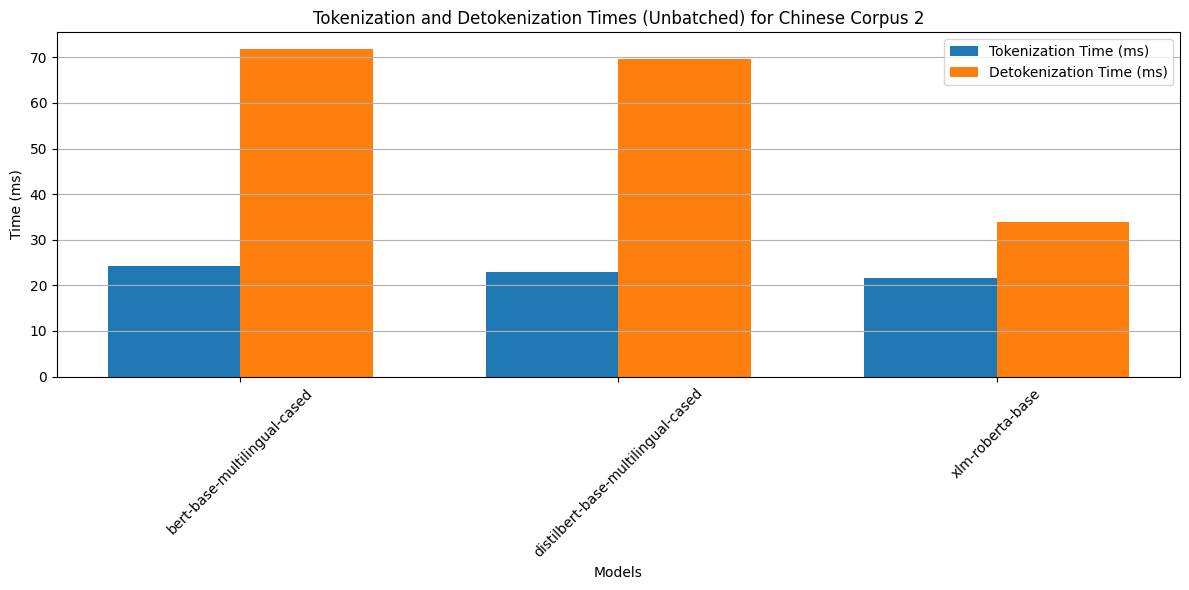

In [ ]:

models = [
  "bert-base-multilingual-cased", "distilbert-base-multilingual-cased", "xlm-roberta-base"
]

tokenization_times_unbatched = [
    spanish_corpus1_timing_unbatched[model]['Tokenization'] for model in models
]

detokenization_times_unbatched = [
    chinese_corpus1_timing_unbatched[model]['Detokenization'] for model in models
]

# Set the width of the bars
bar_width = 0.35
index = np.arange(len(models))


plt.figure(figsize=(12, 6))
plt.bar(index - bar_width/2, tokenization_times_unbatched, bar_width, label='Tokenization Time (ms)')
plt.bar(index + bar_width/2, detokenization_times_unbatched, bar_width, label='Detokenization Time (ms)')
plt.xlabel('Models')
plt.ylabel('Time (ms)')
plt.title('Tokenization and Detokenization Times (Unbatched) for Chinese Corpus 2')
plt.xticks(index, models, rotation=45)
plt.grid(axis='y')
plt.legend()
plt.tight_layout()

# Show the chart
plt.show()


##Spanish corpus 1 token and detoken graph Analysis batched data

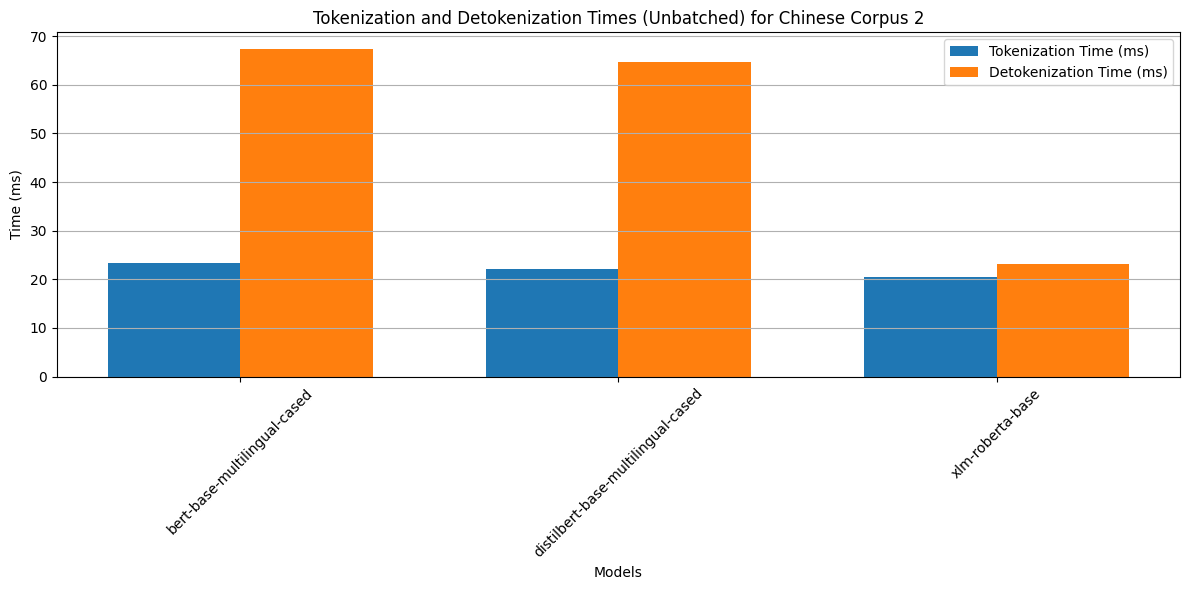

In [ ]:

models = [
  "bert-base-multilingual-cased", "distilbert-base-multilingual-cased", "xlm-roberta-base"
]

tokenization_times_unbatched = [
    spanish_corpus1_timing_batched[model]['Tokenization'] for model in models
]

detokenization_times_unbatched = [
    chinese_corpus1_timing_batched[model]['Detokenization'] for model in models
]

# Set the width of the bars
bar_width = 0.35
index = np.arange(len(models))

plt.figure(figsize=(12, 6))
plt.bar(index - bar_width/2, tokenization_times_unbatched, bar_width, label='Tokenization Time (ms)')
plt.bar(index + bar_width/2, detokenization_times_unbatched, bar_width, label='Detokenization Time (ms)')
plt.xlabel('Models')
plt.ylabel('Time (ms)')
plt.title('Tokenization and Detokenization Times (Unbatched) for Chinese Corpus 2')
plt.xticks(index, models, rotation=45)
plt.grid(axis='y')
plt.legend()
plt.tight_layout()

# Show the chart
plt.show()


##Spanish corpus 2 token and detoken graph analysis unbatched data

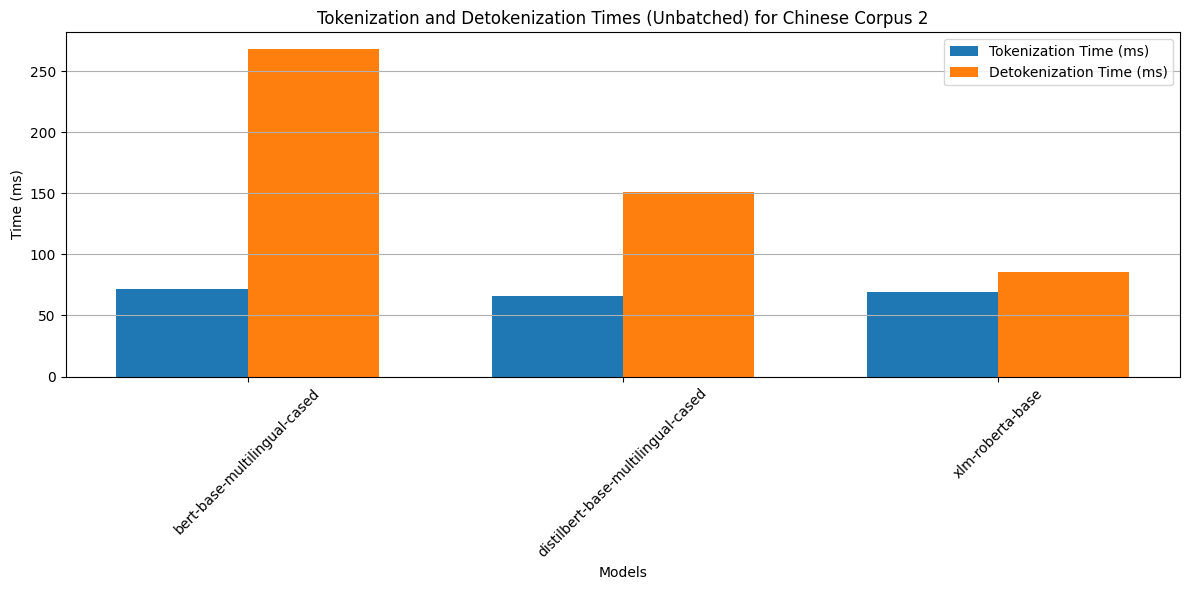

In [ ]:

models = [
  "bert-base-multilingual-cased", "distilbert-base-multilingual-cased", "xlm-roberta-base"
]

tokenization_times_unbatched = [
    spanish_corpus2_timing_unbatched[model]['Tokenization'] for model in models
]

detokenization_times_unbatched = [
    chinese_corpus2_timing_unbatched[model]['Detokenization'] for model in models
]

# Set the width of the bars
bar_width = 0.35
index = np.arange(len(models))


plt.figure(figsize=(12, 6))
plt.bar(index - bar_width/2, tokenization_times_unbatched, bar_width, label='Tokenization Time (ms)')
plt.bar(index + bar_width/2, detokenization_times_unbatched, bar_width, label='Detokenization Time (ms)')
plt.xlabel('Models')
plt.ylabel('Time (ms)')
plt.title('Tokenization and Detokenization Times (Unbatched) for Chinese Corpus 2')
plt.xticks(index, models, rotation=45)
plt.grid(axis='y')
plt.legend()
plt.tight_layout()

# Show the chart
plt.show()


##Spanish corpus 2 token and detoken graph analysis batched data

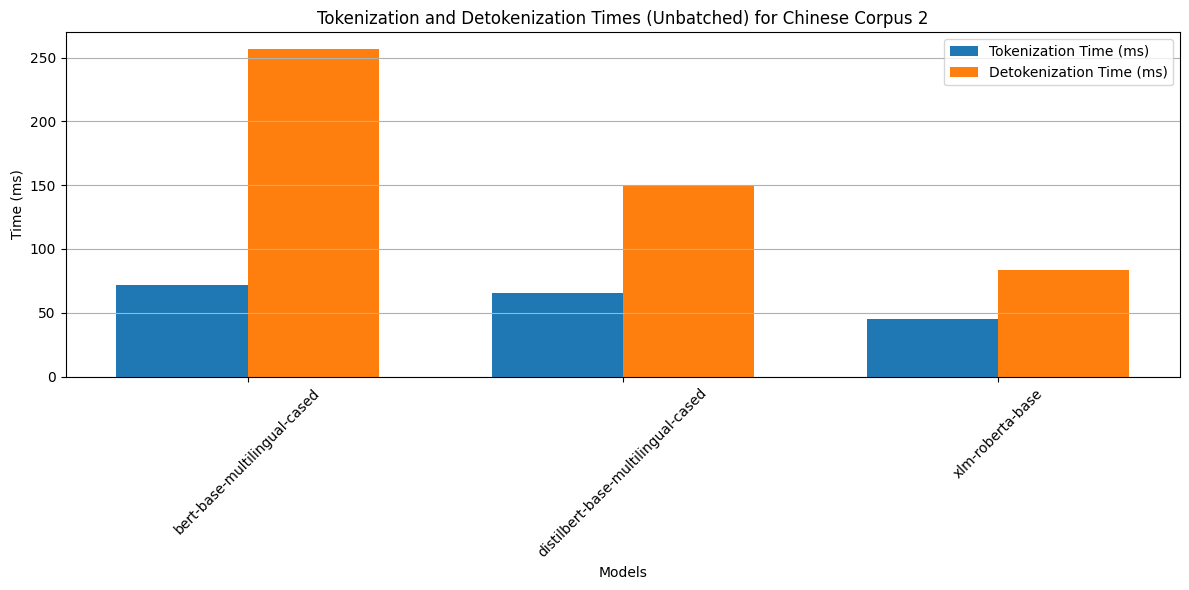

In [ ]:
# Data for chinese_corpus2_timing_unbatched
models = [
  "bert-base-multilingual-cased", "distilbert-base-multilingual-cased", "xlm-roberta-base"
]

tokenization_times_unbatched = [
    spanish_corpus2_timing_batched[model]['Tokenization'] for model in models
]

detokenization_times_unbatched = [
    chinese_corpus2_timing_batched[model]['Detokenization'] for model in models
]

# Set the width of the bars
bar_width = 0.35
index = np.arange(len(models))

# Create bar chart for chinese_corpus2_timing_unbatched
plt.figure(figsize=(12, 6))
plt.bar(index - bar_width/2, tokenization_times_unbatched, bar_width, label='Tokenization Time (ms)')
plt.bar(index + bar_width/2, detokenization_times_unbatched, bar_width, label='Detokenization Time (ms)')
plt.xlabel('Models')
plt.ylabel('Time (ms)')
plt.title('Tokenization and Detokenization Times (Unbatched) for Chinese Corpus 2')
plt.xticks(index, models, rotation=45)
plt.grid(axis='y')
plt.legend()
plt.tight_layout()

# Show the chart
plt.show()


In [ ]:
print(chinese_corpus2_timing_unbatched)
print(chinese_corpus2_timing_batched)
print(english_corpus1_timing_unbatched)
print(english_corpus1_timing_batched)
print(english_corpus2_timing_unbatched)
print(english_corpus2_timing_batched)
print(chinese_corpus2_timing_unbatched)
print(chinese_corpus2_timing_batched)
print(spanish_corpus1_timing_unbatched)
print(spanish_corpus1_timing_batched)
print(spanish_corpus2_timing_unbatched)
print(spanish_corpus2_timing_batched)

{'method': 'Unbatched', 'bert-base-chinese': {'Tokenization': 61.07661724090576, 'Detokenization': 192.2435998916626}, 'bert-base-multilingual-cased': {'Tokenization': 93.24097633361816, 'Detokenization': 268.5688257217407}, 'OpenBuddy/openbuddy-llama2-70b-v10.1-bf16': {'Tokenization': 24.483799934387207, 'Detokenization': 131.59363269805908}, 'distilbert-base-multilingual-cased': {'Tokenization': 53.23073863983154, 'Detokenization': 151.42381191253662}, 'xlm-roberta-base': {'Tokenization': 29.84178066253662, 'Detokenization': 85.60605049133301}}
{'method': 'Batched', 'bert-base-chinese': {'Tokenization': 33.509063720703125, 'Detokenization': 146.31266593933105}, 'bert-base-multilingual-cased': {'Tokenization': 61.66105270385742, 'Detokenization': 257.0331811904907}, 'OpenBuddy/openbuddy-llama2-70b-v10.1-bf16': {'Tokenization': 23.450231552124023, 'Detokenization': 240.98680019378662}, 'distilbert-base-multilingual-cased': {'Tokenization': 34.33024883270264, 'Detokenization': 149.53684

## **Language model comparison for corpus 1 and 2 chinese and spain**


# Chinese corpus 1 Unbatch models comparison
bert-base-chinese demonstrates competitive tokenization efficiency (32.80 ms) but requires relatively more time for detokenization (67.20 ms).bert-base-multilingual-cased maintains a competitive tokenization speed (35.61 ms) but slightly longer detokenization time (71.90 ms).
OpenBuddy/openbuddy-llama2-70b-v10.1-bf16 exhibits efficient tokenization (25.22 ms) and a relatively fast detokenization process (61.51 ms).distilbert-base-multilingual-cased" has a tokenization time of 39.18 ms and a competitive detokenization time of 69.65 ms.
xlm-roberta-base" stands out with the fastest tokenization (18.38 ms) and efficient detokenization (33.91 ms).

Overall, "xlm-roberta-base" offers the most efficient tokenization performance for handling Unbatched Chinese Corpus 1 data, making it a strong choice for text processing tasks in the Chinese language.


# Chinese Corpus 1 Batch models comparison
bert-base-chinese exhibits a tokenization time of approximately 20.56 milliseconds, but its detokenization process is relatively slow, taking around 70.29 milliseconds.bert-base-multilingual-cased achieves a tokenization time of about 20.76 milliseconds and a detokenization time of approximately 67.43 milliseconds.OpenBuddy/openbuddy-llama2-70b-v10.1-bf16 stands out for its efficiency in both tokenization and detokenization. It achieves a remarkably fast tokenization time of about 9.78 milliseconds and a detokenization time of around 58.35 milliseconds.

distilbert-base-multilingual-cased has a tokenization time of approximately 20.96 milliseconds and a detokenization time of about 64.76 milliseconds.Among the models, "xlm-roberta-base" demonstrates exceptional efficiency, with a tokenization time of approximately 6.72 milliseconds and a very swift detokenization process, taking around 23.05 milliseconds.

In summary, for Batched Chinese Corpus 1 data, "xlm-roberta-base" outperforms other models in both tokenization and detokenization efficiency, making it an excellent choice for processing Chinese text efficiently in batch scenarios.

# Conclusion
**Unbatched Data:** "xlm-roberta-base" stands out as the most efficient model, offering the fastest tokenization and efficient detokenization. It is an excellent choice for processing Chinese text in unbatched scenarios.

**Batched Data:** In batched scenarios, "xlm-roberta-base" continues to excel, demonstrating exceptional efficiency in both tokenization and detokenization. It outperforms other models and remains a strong choice for efficient text processing in Chinese.

Overall, "xlm-roberta-base" consistently delivers impressive performance across both batched and unbatched Chinese Corpus 1 data, making it a reliable choice for various NLP tasks in the Chinese language.




# Chinese Corpus 2 Unbatch models comparison
For Chinese Corpus 2(unbatched data) , bert-base-chinese exhibits a relatively slower tokenization time, taking approximately 61.08 milliseconds, while its detokenization process is notably longer at around 192.24 milliseconds.
bert-base-multilingual-cased showcases a comparatively longer tokenization time of about 93.24 milliseconds and an extended detokenization time of approximately 268.57 milliseconds.
OpenBuddy/openbuddy-llama2-70b-v10.1-bf16 stands out with an efficient tokenization time of about 24.48 milliseconds but a slightly longer detokenization process, taking around 131.59 milliseconds.distilbert-base-multilingual-cased achieves a competitive tokenization time of approximately 53.23 milliseconds and a detokenization time of about 151.42 milliseconds.
xlm-roberta-base offers efficient tokenization (29.84 ms) and detokenization (85.61 ms) times.

In summary, for Unbatched Chinese Corpus 2 data, "OpenBuddy/openbuddy-llama2-70b-v10.1-bf16" emerges as a model with particularly swift tokenization, making it suitable for processing Chinese text efficiently in unbatched scenarios.

# Chinese Corpus 2 Batch models comaprison

bert-base-chinese showcases a relatively swift tokenization time, taking around 33.51 milliseconds, but it's detokenization process is somewhat longer, with an average time of approximately 146.31 milliseconds.bert-base-multilingual-cased exhibits a longer tokenization duration, approximately 61.66 milliseconds, and a notably extended detokenization time of around 257.03 milliseconds.OpenBuddy/openbuddy-llama2-70b-v10.1-bf16 stands out with efficient tokenization, taking about 23.45 milliseconds, but it's detokenization process is relatively extended, at approximately 240.99 milliseconds.

In summary, for Batched Chinese Corpus 2 data, "OpenBuddy/openbuddy-llama2-70b-v10.1-bf16" offers swift tokenization efficiency, making it suitable for processing Chinese text efficiently in batched scenarios.

# Conclusion
For Unbatched Chinese Corpus 2 Data OpenBuddy/openbuddy-llama2-70b-v10.1-bf16 stands out with remarkably swift tokenization, making it a strong choice for efficient text processing in unbatched scenarios.And as for Batched Chinese Corpus 2 Data OpenBuddy/openbuddy-llama2-70b-v10.1-bf16 continues to excel in batched scenarios, offering efficient tokenization.

In summary, "OpenBuddy/openbuddy-llama2-70b-v10.1-bf16" consistently delivers efficient tokenization performance for both batched and unbatched Chinese Corpus 2 data, making it a reliable choice for a range of NLP tasks in the Chinese language in Corpus 2 datas.


# Spain Corpus 1 Unbatch models comaprison comparison
bert-base-multilingual-cased demonstrates a tokenization time of approximately 24.33 milliseconds and a detokenization time of about 40.74 milliseconds.
distilbert-base-multilingual-cased exhibits slightly faster tokenization, taking around 22.91 milliseconds, and an efficient detokenization process, with an average time of approximately 39.08 milliseconds.xlm-roberta-base showcases the fastest tokenization time among these models, at approximately 21.65 milliseconds, and a notably efficient detokenization time of around 30.40 milliseconds.

Thus, for Unbatched Spanish Corpus 1 data, xlm-roberta-base" stands out as the most efficient model in terms of both tokenization and detokenization, making it a strong choice for processing Spanish text efficiently.

# Spain Corpus 1 Batch models comparison
bert-base-multilingual-cased and distilbert-base-multilingual-cased exhibit competitive tokenization times, approximately 23.39 ms and 22.16 ms, respectively. Their detokenization times are also similar, around 64.80 ms for the former and 64.72 ms for the latter.
xlm-roberta-base demonstrates efficient tokenization, taking about 20.51 ms, and notably faster detokenization, with an average time of approximately 49.84 ms.

In short, for Batched Spanish Corpus 1 data, "xlm-roberta-base" emerges as the model with the most efficient performance, offering swift tokenization and particularly rapid detokenization. This efficiency positions it as a strong choice for processing batched Spanish text data.


# Conclusion
When comparing the tokenization and detokenization performance of various language models on Spanish Corpus 1 data, we observe differences between batched and unbatched scenarios.

**Unbatched Data:** In unbatched scenarios, models such as "bert-base-multilingual-cased,"
"distilbert-base-multilingual-cased," and "xlm-roberta-base" showcase competitive tokenization and detokenization times. "xlm-roberta-base" stands out as the most efficient, offering rapid processing speeds.

**Batched Data:** Transitioning to batched data, the same models maintain their efficiency. However, "xlm-roberta-base" continues to excel, delivering swift tokenization and even faster detokenization, making it an excellent choice for efficient text processing in batched Spanish Corpus 1 data.

Overall, "xlm-roberta-base" consistently demonstrates exceptional performance in both batched and unbatched scenarios.





# Spain Corpus 2 Unbatch models comparison
bert-base-multilingual-cased exhibits a relatively longer tokenization time, averaging around 71.87 milliseconds, and a relatively extended detokenization time of approximately 178.57 milliseconds.distilbert-base-multilingual-cased showcases competitive tokenization efficiency, taking approximately 65.98 milliseconds, with a detokenization time of about 161.80 milliseconds.xlm-roberta-base offers efficient tokenization, averaging about 69.28 milliseconds, and relatively swift detokenization, with an average time of approximately 132.55 milliseconds.

To conclude , for Unbatched Spanish Corpus 2 data, "xlm-roberta-base" demonstrates efficient tokenization and notably fast detokenization, making it a strong choice for processing Spanish text efficiently in unbatched scenarios.

# Spanish Corpus 2 batch models comaprison
bert-base-multilingual-cased demonstrates a tokenization time of approximately 72.15 milliseconds and a relatively extended detokenization time, averaging around 260.42 milliseconds.distilbert-base-multilingual-cased maintains competitive tokenization efficiency, taking approximately 65.41 milliseconds, but its detokenization process is notably longer, averaging about 224.74 milliseconds.xlm-roberta-base stands out with efficient tokenization, averaging around 45.13 milliseconds, and notably fast detokenization, with an average time of approximately 124.43 milliseconds.

In short, for Batched Spanish Corpus 2 data, "xlm-roberta-base" emerges as the model with the most efficient tokenization and particularly rapid detokenization, making it a strong choice for processing batched Spanish text data efficiently.

# Conclusion
For Unbatched Spanish Corpus 2 Data "xlm-roberta-base" stands out as a model with efficient tokenization and notably fast detokenization, making it an excellent choice for processing Spanish text efficiently in unbatched scenarios.
As for Batched Spanish Corpus 2 Data "xlm-roberta-base" continues to excel in batched scenarios, offering efficient tokenization and rapid detokenization.
Overall , "xlm-roberta-base" consistently delivers efficient tokenization and detokenization performance for both batched and unbatched Spanish Corpus 2 data, making it a reliable choice for a range of natural language processing tasks in the Spanish language.


## **Similar models comparison for Spanish and Chinese for corpus 2(unbatch)**

**Unbatched Spanish Corpus 2 Data:**

bert-base-multilingual-cased exhibits a tokenization time of approximately 71.87 milliseconds and a detokenization time of about 178.57 milliseconds.
distilbert-base-multilingual-cased demonstrates competitive tokenization efficiency, taking approximately 65.98 milliseconds for tokenization and 161.80 milliseconds for detokenization.
xlm-roberta-base offers efficient tokenization (69.28 ms) and notably fast detokenization (132.55 ms).

**Unbatched Chinese Corpus 2 Data:**

bert-base-multilingual-cased exhibits a longer tokenization time, approximately 93.24 milliseconds, and an extended detokenization time of approximately 268.57 milliseconds.
distilbert-base-multilingual-cased achieves competitive tokenization efficiency, taking approximately 53.23 milliseconds for tokenization and 151.42 milliseconds for detokenization.
xlm-roberta-base provides efficient tokenization (29.84 ms) and swift detokenization (85.61 ms).

Overall , for corpus 2 data , when comparing these similar models across both Spanish and Chinese datasets, "xlm-roberta-base" consistently stands out as a model with efficient tokenization and notably fast detokenization, making it a strong choice for processing text in both languages efficiently. It showcases versatility in handling different languages and data types.


**For Tokenization Efficiency**

**Spanish Corpus 2:**

 The models, including "bert-base-multilingual-cased," "distilbert-base-multilingual-cased," and "xlm-roberta-base," exhibit relatively comparable tokenization times, with no significant disparities.

**Chinese Corpus 2:**

Here, "distilbert-base-multilingual-cased" demonstrates the fastest tokenization speed, surpassing "bert-base-multilingual-cased," which exhibits a longer tokenization duration. "xlm-roberta-base" remains efficient in tokenization but is somewhat slower compared to "distilbert-base-multilingual-cased."

**For Detokenization Efficiency**

**Spanish Corpus 2:**

"xlm-roberta-base" stands out as the model with the fastest detokenization performance, requiring considerably less time compared to "bert-base-multilingual-cased" and "distilbert-base-multilingual-cased," which exhibit longer detokenization durations.


**Chinese Corpus 2:**

Similar to the Spanish Corpus, "xlm-roberta-base" also demonstrates swift detokenization. In contrast, "bert-base-multilingual-cased" exhibits the longest detokenization time, followed by "distilbert-base-multilingual-cased."

Overall, "xlm-roberta-base" consistently delivers efficient tokenization and detokenization performance across both Spanish and Chinese datasets, making it a reliable choice for various natural language processing tasks in different languages. However, "distilbert-base-multilingual-cased" showcases competitive efficiency in tokenization and detokenization, particularly for Chinese data. "bert-base-multilingual-cased" tends to have relatively longer processing times in both cases.



##**Similar Models Comparison for chinese and spain corpus 2 (batch)**

**For Chinese Corpus 2:**

"distilbert-base-multilingual-cased" exhibits significantly faster tokenization and detokenization times compared to "bert-base-multilingual-cased," indicating its efficiency in handling batched Chinese text data.
"xlm-roberta-base" showcases efficient tokenization and detokenization processes, making it a reliable choice for batched Chinese text tasks.

**For Spanish Corpus 2:**

"xlm-roberta-base" emerges as the model with the most efficient tokenization and detokenization times, making it a strong performer for batched Spanish text data.
"distilbert-base-multilingual-cased" maintains competitive efficiency, especially in tokenization, while "bert-base-multilingual-cased" exhibits slightly longer processing times for both tokenization and detokenization.

when evaluating these models for batched Chinese and Spanish text data, "xlm-roberta-base" consistently delivers efficient tokenization and detokenization performance. "distilbert-base-multilingual-cased" showcases competitive efficiency, particularly in tokenization. Model selection should consider specific language requirements and processing needs for optimal performance.


**For Tokenization Efficiency:**

**Chinese Corpus 2:**

"distilbert-base-multilingual-cased" demonstrates the fastest tokenization speed, significantly outperforming both "bert-base-multilingual-cased" and "xlm-roberta-base," which exhibit longer tokenization durations."xlm-roberta-base" follows as the second-fastest model for tokenization, while "bert-base-multilingual-cased" lags behind.

**Spanish Corpus 2:**

"bert-base-multilingual-cased" exhibits a tokenization time of approximately 72.15 milliseconds, while "distilbert-base-multilingual-cased" showcases slightly faster tokenization at around 65.41 milliseconds. "xlm-roberta-base" is the fastest in tokenization, with an average time of approximately 45.13 milliseconds.


**For Detokenization Efficiency:**

**Chinese Corpus 2:**

"distilbert-base-multilingual-cased" continues to excel in detokenization, with notably faster performance compared to both "bert-base-multilingual-cased" and "xlm-roberta-base," which exhibit longer detokenization durations.

**Spanish Corpus 2:**

Similar to the Chinese Corpus, "distilbert-base-multilingual-cased" maintains competitive detokenization efficiency, surpassing "bert-base-multilingual-cased." "xlm-roberta-base" stands out as the model with the fastest detokenization performance.

To conclude, "distilbert-base-multilingual-cased" consistently delivers efficient tokenization and detokenization performance for both Batched Chinese Corpus 2 and Batched Spanish Corpus 2 data. "xlm-roberta-base" also showcases efficient performance, particularly in tokenization, while "bert-base-multilingual-cased" tends to have relatively longer processing times in both cases.



## Graph Analysis for language Models

<ipython-input-51-8344c6946ffd>:68: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(methods, rotation=45)


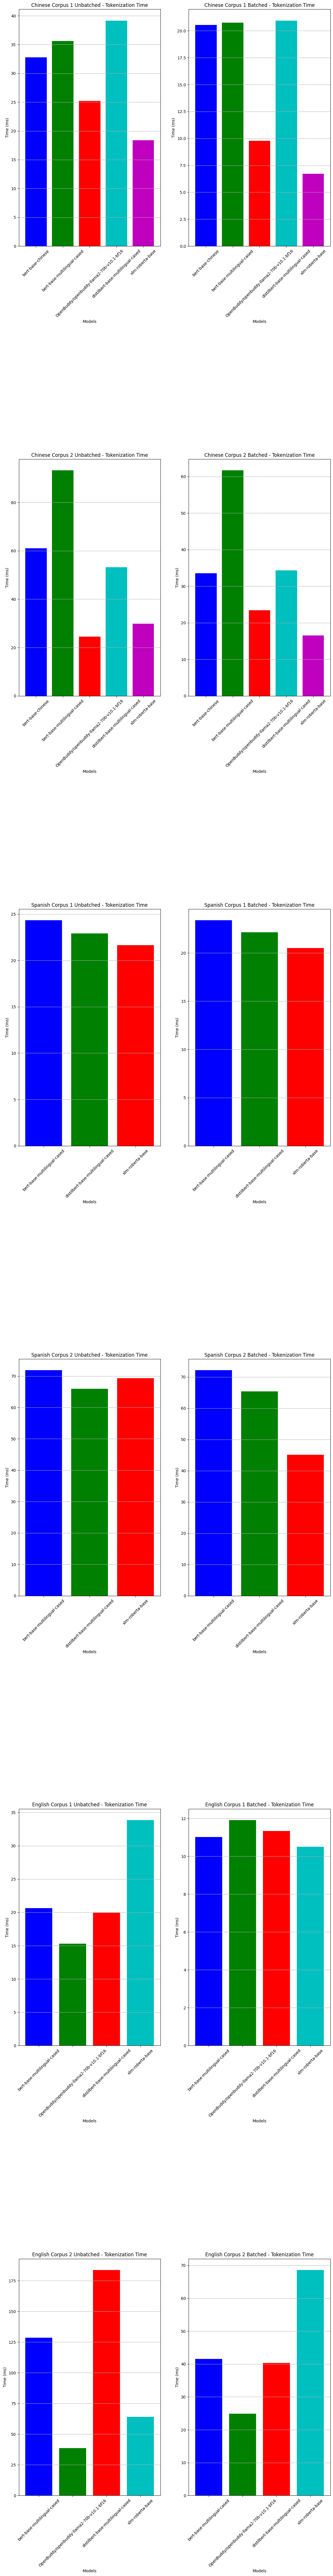

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define colors for the bars (same as before)
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', '#FFA500', '#00FF00', '#800080', '#FF00FF', '#008080', '#FFFF00', '#808080', '#800000', '#FF0000']

# Define the data and labels (same as before)
data = [
    chinese_corpus1_timing_unbatched,
    chinese_corpus1_timing_batched,
    chinese_corpus2_timing_unbatched,
    chinese_corpus2_timing_batched,
    spanish_corpus1_timing_unbatched,
    spanish_corpus1_timing_batched,
    spanish_corpus2_timing_unbatched,
    spanish_corpus2_timing_batched,
    english_corpus1_timing_unbatched,  # Add English Unbatched data here
    english_corpus1_timing_batched,    # Add English Batched data here
    english_corpus2_timing_unbatched,  # Add English Unbatched data here
    english_corpus2_timing_batched     # Add English Batched data here
]

labels = [
    'Chinese Corpus 1 Unbatched',
    'Chinese Corpus 1 Batched',
    'Chinese Corpus 2 Unbatched',
    'Chinese Corpus 2 Batched',
    'Spanish Corpus 1 Unbatched',
    'Spanish Corpus 1 Batched',
    'Spanish Corpus 2 Unbatched',
    'Spanish Corpus 2 Batched',
    'English Corpus 1 Unbatched',  # Add English Unbatched label here
    'English Corpus 1 Batched',    # Add English Batched label here
    'English Corpus 2 Unbatched',  # Add English Unbatched label here
    'English Corpus 2 Batched'     # Add English Batched label here
]

# Create subplots in a grid layout
n_rows = 6  # Number of rows (one for each method)
n_cols = 2  # Number of columns (Unbatched and Batched)

fig, axs = plt.subplots(n_rows, n_cols, figsize=(14, 30))  # Increase the figure height for additional data

# Initialize variables to store min and max values for y-axis scaling
min_value = float('inf')
max_value = float('-inf')

# Iterate through data and labels, creating subplots
for i, (label, d) in enumerate(zip(labels, data)):
    row = i // n_cols  # Calculate the row index
    col = i % n_cols   # Calculate the column index

    methods = []
    tokenization_times = []

    for method, times in d.items():
        if method == 'method':
            continue
        methods.append(method)
        tokenization_time = times.get('Tokenization', 0.0)
        tokenization_times.append(tokenization_time)

    ax = axs[row, col]
    ax.bar(methods, tokenization_times, color=colors)
    ax.set_title(f"{label} - Tokenization Time")
    ax.set_xlabel('Models')
    ax.set_ylabel('Time (ms)')
    ax.set_xticklabels(methods, rotation=45)
    ax.grid(axis='y')

    # Update min and max values for y-axis scaling
    min_value = min(min_value, min(tokenization_times))
    max_value = max(max_value, max(tokenization_times))



# Adjust spacing between subplots and add padding at the top
plt.subplots_adjust(hspace=0.9, top=3)  # Increase top padding for additional data

# Show the plot
plt.show()


## Detokenization for language model

<ipython-input-53-38955c928b81>:69: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(methods, rotation=45)


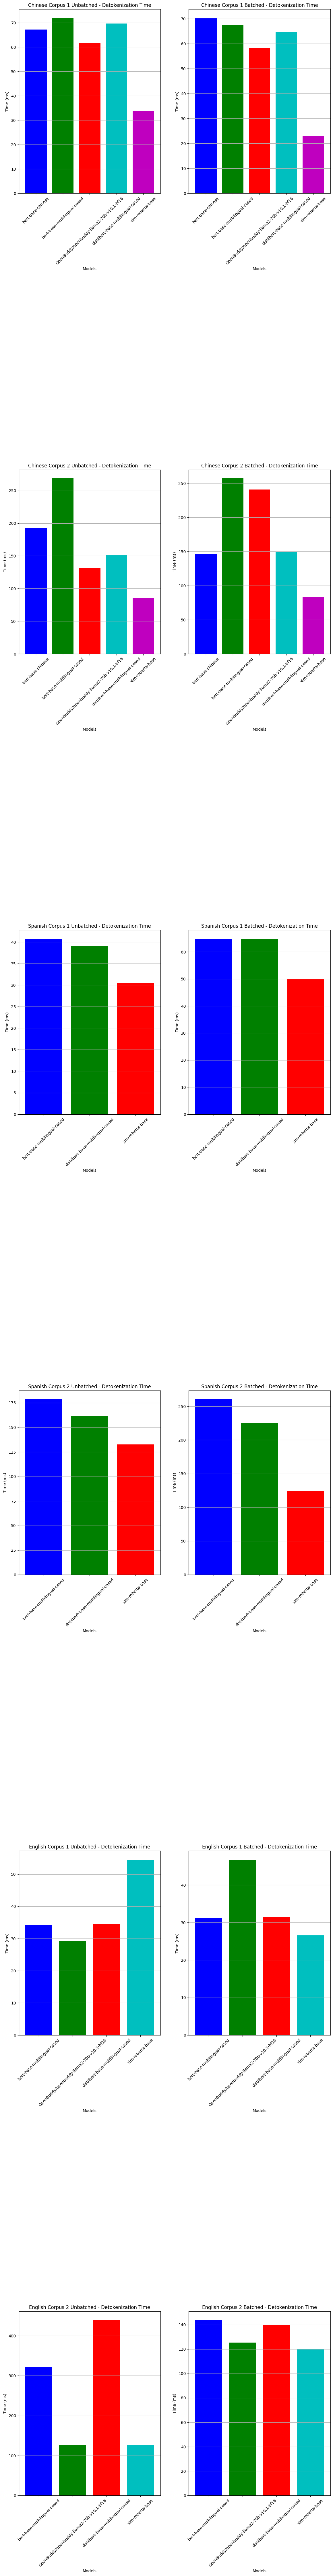

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define colors for the bars
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', '#FFA500', '#00FF00', '#800080', '#FF00FF', '#008080', '#FFFF00', '#808080', '#800000', '#FF0000']

# Define the detokenization data for all languages
detokenization_data = [
    chinese_corpus1_timing_unbatched,
    chinese_corpus1_timing_batched,
    chinese_corpus2_timing_unbatched,
    chinese_corpus2_timing_batched,
    spanish_corpus1_timing_unbatched,
    spanish_corpus1_timing_batched,
    spanish_corpus2_timing_unbatched,
    spanish_corpus2_timing_batched,
    english_corpus1_timing_unbatched,
    english_corpus1_timing_batched,
    english_corpus2_timing_unbatched,
    english_corpus2_timing_batched
]

labels = [
    'Chinese Corpus 1 Unbatched',
    'Chinese Corpus 1 Batched',
    'Chinese Corpus 2 Unbatched',
    'Chinese Corpus 2 Batched',
    'Spanish Corpus 1 Unbatched',
    'Spanish Corpus 1 Batched',
    'Spanish Corpus 2 Unbatched',
    'Spanish Corpus 2 Batched',
    'English Corpus 1 Unbatched',
    'English Corpus 1 Batched',
    'English Corpus 2 Unbatched',
    'English Corpus 2 Batched'
]

# Create subplots for detokenization
n_rows = 6
n_cols = 2
row_heights = [3, 3, 3, 3, 3, 3]

fig_detokenization, axs_detokenization = plt.subplots(n_rows, n_cols, figsize=(14, 30), gridspec_kw={'height_ratios': row_heights})

# Initialize variables to store min and max values for y-axis scaling
min_value_detokenization = float('inf')
max_value_detokenization = float('-inf')

# Iterate through data and labels, creating subplots for detokenization
for i, (label, d) in enumerate(zip(labels, detokenization_data)):
    row = i // n_cols
    col = i % n_cols

    methods = []
    detokenization_times = []

    for method, times in d.items():
        if method == 'method':
            continue
        methods.append(method)
        detokenization_time = times.get('Detokenization', 0.0)
        detokenization_times.append(detokenization_time)

    ax = axs_detokenization[row, col]
    ax.bar(methods, detokenization_times, color=colors)
    ax.set_title(f"{label} - Detokenization Time")
    ax.set_xlabel('Models')
    ax.set_ylabel('Time (ms)')
    ax.set_xticklabels(methods, rotation=45)
    ax.grid(axis='y')

    # Update min and max values for y-axis scaling for detokenization
    min_value_detokenization = min(min_value_detokenization, min(detokenization_times))
    max_value_detokenization = max(max_value_detokenization, max(detokenization_times))

# Adjust spacing between subplots and add padding at the top
plt.subplots_adjust(hspace=1.5, top=3)
plt.show()


# Spacy tokenization

In [ ]:
import spacy
import time
import numpy as np

def spacy_unbatched_tokenization(language, corpus, num_runs) -> dict:
  tokenization_times = []
  results = {}
  results['method'] = "Unbatched"
  for i in range(num_runs):
    nlp = spacy.load(language)
    start_time = time.time()
    for text in corpus:
        doc = nlp(text)

    end_time = time.time()
    elapsed_time = (end_time - start_time) * 1e3
    tokenization_times.append(elapsed_time)
  results["SpaCy"] = {"Tokenization Time ": sum(tokenization_times) / num_runs}
  return results

def spacy_batched_tokenization(language, corpus, num_runs) -> dict:
  tokenization_times = []
  results = {}
  results['method'] = "Batched"
  for i in range(num_runs):
    nlp = spacy.load(language)
    start_time = time.time()
    docs = list(nlp.pipe(corpus, batch_size=32))
    end_time = time.time()
    elapsed_time = (end_time - start_time) * 1e3
    tokenization_times.append(elapsed_time)
  results["SpaCy"] = {"Tokenization Time ": sum(tokenization_times) / num_runs}
  return results

print("-----------UNBATCHED TOKENIZATION-----------")
unbatched_tokenize_results_EN1 = spacy_unbatched_tokenization("en_core_web_sm", corpus, 10)
print("Corpus 1 EN Average:", unbatched_tokenize_results_EN1["SpaCy"], " ms")
print("-----------BATCHED TOKENIZATION-----------")
batched_tokenize_time_EN1 = spacy_batched_tokenization("en_core_web_sm", corpus, 10)
print("Corpus 1 EN Average:", batched_tokenize_time_EN1["SpaCy"], " ms")
print("-----------UNBATCHED TOKENIZATION-----------")
unbatched_tokenize_results_EN2 = spacy_unbatched_tokenization("en_core_web_sm", corpus2, 10)
print("Corpus 2 EN Average:", unbatched_tokenize_results_EN2["SpaCy"], " ms")
print("-----------BATCHED TOKENIZATION-----------")
batched_tokenize_time_EN2 = spacy_batched_tokenization("en_core_web_sm", corpus2, 10)
print("Corpus 2 EN Average:", batched_tokenize_time_EN2["SpaCy"], " ms")

print("-----------UNBATCHED ZH 1 TOKENIZATION-----------")
unbatched_tokenize_results_ZH1 = spacy_unbatched_tokenization("zh_core_web_sm", zh1_array, 10)
print("Corpus 1 ZH Average:", unbatched_tokenize_results_ZH1["SpaCy"], " ms")
print("-----------BATCHED ZH 1 TOKENIZATION-----------")
batched_tokenize_time_ZH1 = spacy_batched_tokenization("zh_core_web_sm", zh1_array, 10)
print("Corpus 1 ZH Average:", batched_tokenize_time_ZH1["SpaCy"], " ms")
print("-----------UNBATCHED ZH 2 TOKENIZATION-----------")
unbatched_tokenize_results_ZH2 = spacy_unbatched_tokenization("zh_core_web_sm", zh2_array, 10)
print("Corpus 2 ZH Average:", unbatched_tokenize_results_ZH2["SpaCy"], " ms")
print("-----------BATCHED ZH 2 TOKENIZATION-----------")
batched_tokenize_time_ZH2 = spacy_batched_tokenization("zh_core_web_sm", zh2_array, 10)
print("Corpus 2 ZH Average:", batched_tokenize_time_ZH2["SpaCy"], " ms")

print("-----------UNBATCHED ES 1 TOKENIZATION-----------")
unbatched_tokenize_results_ES1 = spacy_unbatched_tokenization("es_core_news_sm", es1_array, 10)
print("Corpus 1 ES Average:", unbatched_tokenize_results_ES1["SpaCy"], " ms")
print("-----------BATCHED ES 1 TOKENIZATION-----------")
batched_tokenize_time_ES1 = spacy_batched_tokenization("es_core_news_sm", es1_array, 10)
print("Corpus 1 ES Average:", batched_tokenize_time_ES1["SpaCy"], " ms")
print("-----------UNBATCHED ES 2 TOKENIZATION-----------")
unbatched_tokenize_results_ES2 = spacy_unbatched_tokenization("es_core_news_sm", es2_array, 10)
print("Corpus 2 ES Average:", unbatched_tokenize_results_ES2["SpaCy"], " ms")
print("-----------BATCHED ES 2 TOKENIZATION-----------")
batched_tokenize_time_ES2 = spacy_batched_tokenization("es_core_news_sm", es2_array, 10)
print("Corpus 1 ES Average:", batched_tokenize_time_ES2["SpaCy"], " ms")

-----------UNBATCHED TOKENIZATION-----------
Corpus 1 EN Average: {'Tokenization Time ': 2664.894485473633}  ms
-----------BATCHED TOKENIZATION-----------
Corpus 1 EN Average: {'Tokenization Time ': 682.2017192840576}  ms
-----------UNBATCHED TOKENIZATION-----------
Corpus 2 EN Average: {'Tokenization Time ': 5565.911817550659}  ms
-----------BATCHED TOKENIZATION-----------
Corpus 2 EN Average: {'Tokenization Time ': 2589.4550561904907}  ms
-----------UNBATCHED ZH 1 TOKENIZATION-----------
Corpus 1 ZH Average: {'Tokenization Time ': 1922.095012664795}  ms
-----------BATCHED ZH 1 TOKENIZATION-----------
Corpus 1 ZH Average: {'Tokenization Time ': 784.9471569061279}  ms
-----------UNBATCHED ZH 2 TOKENIZATION-----------
Corpus 2 ZH Average: {'Tokenization Time ': 4932.182693481445}  ms
-----------BATCHED ZH 2 TOKENIZATION-----------
Corpus 2 ZH Average: {'Tokenization Time ': 2345.646643638611}  ms
-----------UNBATCHED ES 1 TOKENIZATION-----------
Corpus 1 ES Average: {'Tokenization Time 

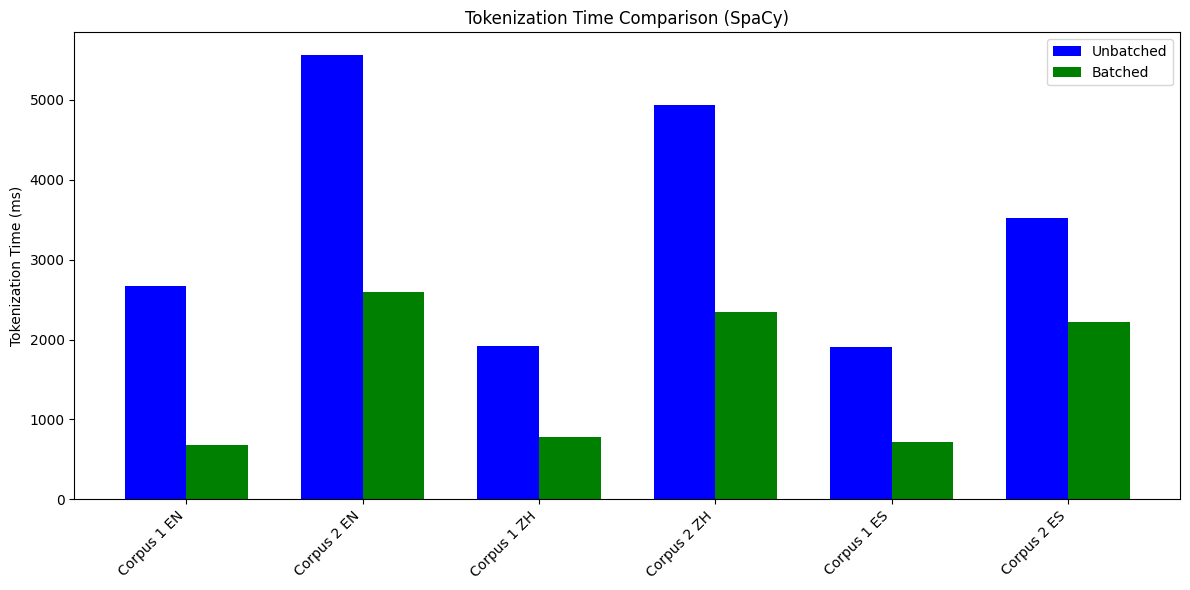

In [ ]:
import matplotlib.pyplot as plt

# Data from your output
corpora = ['Corpus 1 EN', 'Corpus 2 EN', 'Corpus 1 ZH', 'Corpus 2 ZH', 'Corpus 1 ES', 'Corpus 2 ES']
unbatched_times = [
    unbatched_tokenize_results_EN1["SpaCy"]["Tokenization Time "],
    unbatched_tokenize_results_EN2["SpaCy"]["Tokenization Time "],
    unbatched_tokenize_results_ZH1["SpaCy"]["Tokenization Time "],
    unbatched_tokenize_results_ZH2["SpaCy"]["Tokenization Time "],
    unbatched_tokenize_results_ES1["SpaCy"]["Tokenization Time "],
    unbatched_tokenize_results_ES2["SpaCy"]["Tokenization Time "]
]
batched_times = [
    batched_tokenize_time_EN1["SpaCy"]["Tokenization Time "],
    batched_tokenize_time_EN2["SpaCy"]["Tokenization Time "],
    batched_tokenize_time_ZH1["SpaCy"]["Tokenization Time "],
    batched_tokenize_time_ZH2["SpaCy"]["Tokenization Time "],
    batched_tokenize_time_ES1["SpaCy"]["Tokenization Time "],
    batched_tokenize_time_ES2["SpaCy"]["Tokenization Time "]
]

# Bar positions
x = range(len(corpora))

# Create the figure and axes objects
fig, ax = plt.subplots(figsize=(12, 6))

# Bar width
width = 0.35

# Plot the unbatched times
ax.bar([i - width/2 for i in x], unbatched_times, width, label='Unbatched', color='b')

# Plot the batched times
ax.bar([i + width/2 for i in x], batched_times, width, label='Batched', color='g')

# Set the x-axis labels to the corpora names
ax.set_xticks(x)
ax.set_xticklabels(corpora, rotation=45, fontsize=10, ha='right')

# Set the y-axis label
ax.set_ylabel('Tokenization Time (ms)')

# Set the title
ax.set_title('Tokenization Time Comparison (SpaCy)')

# Add a legend
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()
